Projet de Machine Learning : expliquer le prix de l'électricité

Romain Foucher
Matthieu Evuort
Julie Chen


Introduction :

Le machine learning est une technique informatique qui permet à une machine d'apprendre à partir de données, sans qu'un programme spécifique lui soit directement programmé. Le principe est de fournir à l'algorithme un grand nombre d'exemples pour qu'il apprenne à identifier des modèles et à prendre des décisions à partir de ces modèles. Le machine learning est utilisé dans de nombreux domaines, tels que la reconnaissance de formes, la classification de données, la détection de fraudes, la recommandation de produits, la traduction de langues, la reconnaissance vocale ou encore la conduite autonome.

Ce projet consiste à expliquer le prix de l'électricité en France et en Allemagne selon une multitude de facteurs. On peut citer le climat, le réchauffement climatique, les événements géopolitiques... De plus, chaque pays s’appuie sur un mix  énergétique qui lui est propre (nucléaire, solaire, hydrolique, gaz, charbon, etc).

 Pour cela, nous allons utiliser plusieurs méthodes afin de préparer nos données, de les analyser et de les modéliser grâce aux cours et aux TP que nous avons pu effectuer en cours, mais ainsi qu'à la documentation d'internet.

Sommaire :

A) Préparation des données
B) Analyse exploratoire des données
C) Modélisation des données
D) Evaluation des modèles


A) Préparation des données

Afin de préparer nos données, nous allons remplir les cases vides par la moyenne de la colonne. En effet, si nous supprimons les lignes ou les colonnes, nous perdrons des informations et nous réduisons la taille de l'échantillon. Cependant, nous n'allons pas supprimer ou remplacer les données "0.0" car elles sont utiles. En effet, il est possible que la variation du prix du charbon ou du gaz d'un pays ne change pas d'une journée à l'autre.

In [292]:
import ax as ax
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
data_x = pd.read_csv('Data_X.csv')
data_y = pd.read_csv('Data_Y.csv')
data_new_x = pd.read_csv('DataNew_X.csv')

# remplacement des valeurs null par la moyenne de la colonne
for col in data_x.columns[data_x.isnull().any()]:
    data_x[col].fillna(data_x[col].mean(), inplace=True)
print(data_x)

        ID  DAY_ID COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE   
0     1054     206      FR        0.210099       -0.427458       -0.606523  \
1     2049     501      FR       -0.022399       -1.003452       -0.022063   
2     1924     687      FR        1.395035        1.978665        1.021305   
3      297     720      DE       -0.983324       -0.849198       -0.839586   
4     1101     818      FR        0.143807       -0.617038       -0.924990   
...    ...     ...     ...             ...             ...             ...   
1489   459     809      DE        1.529204        1.106682       -1.855327   
1490  1674     887      FR        1.618582        1.752840        0.611392   
1491   748    1083      DE        0.856399        0.489199       -0.255778   
1492  1454    1133      FR        0.560689       -0.343777       -0.830239   
1493   359    1118      DE        0.226730       -0.711005        0.873016   

      FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPO

Ensuite, nous fusionnons data_x et data_y pour comparer nos valeurs d'entrées avec nos valeurs de sorties en joignant sur l'ID. Puis, nous trions sur DAY_ID et COUNTRY pour une meilleure lisibilité.

In [293]:
# fusion de data_x et data_y
merged_X_Y = pd.merge(data_x, data_y, on='ID', how='inner')

# triage des données
merged_X_Y = merged_X_Y.sort_values(by=['DAY_ID', 'COUNTRY'])
print(merged_X_Y)

        ID  DAY_ID COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE   
742   1057       0      FR        0.048418       -0.465067       -0.079296  \
1211  1179       1      FR        0.966997        1.222131        0.331356   
1468   111       2      DE       -0.068972       -0.667390       -1.102015   
1408  1327       2      FR       -0.068972       -0.667390       -1.102015   
680    800       3      DE       -0.134670       -0.834564       -1.051716   
...    ...     ...     ...             ...             ...             ...   
986    771    1212      DE       -0.046100       -0.520506       -0.270515   
1007  1987    1212      FR       -0.046100       -0.520506       -0.270515   
1465   472    1213      DE        1.407027        1.313254       -0.456126   
873   1688    1213      FR        1.407027        1.313254       -0.456126   
1437  1049    1215      FR        0.544810       -0.378158       -0.065993   

      FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPO

Puisque nous étudions la France et l'Allemagne, nous créons deux datas : data_FR et data_DE et nous ajoutons leurs colonnes respectives sans oublier de mettre TARGET.

In [294]:
# création de deux datas pour la France et l'Allemagne
data_FR = merged_X_Y.loc[merged_X_Y['COUNTRY'] == 'FR']
data_DE = merged_X_Y.loc[merged_X_Y['COUNTRY'] == 'DE']

# triage des deux datas avec leurs valeurs correspondantes
data_FR = data_FR.filter(regex='FR|GAS_RET|COAL_RET|TARGET', axis=1)
print(data_FR)

data_DE = data_DE.filter(regex='DE|GAS_RET|COAL_RET|TARGET', axis=1)
print(data_DE)


      FR_CONSUMPTION  DE_FR_EXCHANGE  FR_DE_EXCHANGE  FR_NET_EXPORT   
742        -0.465067       -0.079296        0.079296       0.650577  \
1211        1.222131        0.331356       -0.331356       0.778627   
1408       -0.667390       -1.102015        1.102015       0.256736   
329        -0.834564       -1.051716        1.051716      -0.612133   
512        -0.470371        0.144615       -0.144615      -1.811403   
...              ...             ...             ...            ...   
479        -0.709011        0.427976       -0.427976      -1.678101   
1451        1.301061        1.565552       -1.565552      -0.072643   
1007       -0.520506       -0.270515        0.270515      -0.789824   
873         1.313254       -0.456126        0.456126      -0.069222   
1437       -0.378158       -0.065993        0.065993       0.257829   

      FR_NET_IMPORT    FR_GAS   FR_COAL  FR_HYDRO  FR_NUCLEAR  FR_SOLAR   
742       -0.650577 -0.261565  0.095197  0.677089   -0.357168  1.185155 

Les valeurs des différents attributs sont comparables, car ce sont toutes des variations dans le temps. Nous n'avons pas besoin de normaliser les données.

B) Analyse exploratoire des données

Afin de faire un aperçu des données, nous utilisons plusieurs fonctions :


In [295]:
# affiche le type de chaque colonne et si elles sont nulles ou non
data_FR.info()
data_DE.info()

# affiche la distribution, la plage de valeurs et la signification de chaque colonne
data_FR.describe()
data_DE.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 851 entries, 742 to 1437
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   FR_CONSUMPTION    851 non-null    float64
 1   DE_FR_EXCHANGE    851 non-null    float64
 2   FR_DE_EXCHANGE    851 non-null    float64
 3   FR_NET_EXPORT     851 non-null    float64
 4   FR_NET_IMPORT     851 non-null    float64
 5   FR_GAS            851 non-null    float64
 6   FR_COAL           851 non-null    float64
 7   FR_HYDRO          851 non-null    float64
 8   FR_NUCLEAR        851 non-null    float64
 9   FR_SOLAR          851 non-null    float64
 10  FR_WINDPOW        851 non-null    float64
 11  FR_RESIDUAL_LOAD  851 non-null    float64
 12  FR_RAIN           851 non-null    float64
 13  FR_WIND           851 non-null    float64
 14  FR_TEMP           851 non-null    float64
 15  GAS_RET           851 non-null    float64
 16  COAL_RET          851 non-null    float64
 17 

,DE_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,DE_NET_IMPORT,DE_GAS,DE_COAL,DE_HYDRO,DE_NUCLEAR,DE_SOLAR,DE_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,DE_RAIN,DE_WIND,DE_TEMP,GAS_RET,COAL_RET,TARGET
count,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000
mean,0.379809,-0.172616,0.172616,-0.327798,0.327798,0.814385,-0.255720,0.606018,-0.601507,0.301190,0.154515,-0.448017,0.011554,-0.038166,0.225552,0.006103,0.082186,0.051654,0.148044
std,0.682092,0.988550,0.988550,0.930585,0.930585,0.848854,0.773450,1.083933,0.882778,1.088365,1.070344,0.789194,0.844800,0.967171,1.046143,0.909617,1.105919,1.022188,1.047022
min,-2.265563,-2.856874,-2.634831,-2.464849,-2.279619,-1.004008,-1.491593,-1.373985,-2.689387,-1.442296,-1.235802,-2.879041,-2.613569,-2.128531,-1.880419,-4.549638,-5.349463,-5.392852,-3.075929
25%,-0.069473,-0.979886,-0.640639,-1.026464,-0.365121,0.166714,-0.907156,-0.227007,-1.339070,-0.689997,-0.688578,-0.904350,-0.482059,-0.621853,-0.561814,-0.568777,-0.604950,-0.455707,-0.324693
50%,0.288112,-0.172069,0.172069,-0.404441,0.404441,0.809862,-0.325659,0.402352,-0.343602,0.296254,-0.078279,-0.289221,0.071007,-0.207939,0.070153,0.009451,0.034673,0.047114,0.005057
75%,0.895751,0.640639,0.979886,0.365121,1.026464,1.445299,0.283322,1.342489,0.070503,1.224825,0.643680,0.119871,0.575759,0.268913,0.741858,0.519411,0.691052,0.634172,0.386596
max,2.033851,2.634831,2.856874,2.279619,2.464849,3.118082,1.902490,4.181936,0.842046,2.696571,3.509017,1.070902,2.254155,7.756118,5.085624,2.858758,5.674778,3.607281,7.138604


info() permet d'afficher le type de chaque colonne et si elles sont nulles ou non.
describe() permet d'afficher la somme de toutes les lignes de chaque colonne avec "count", la moyenne de la colonne avec "mean", l'écart-type de la colonne avec "std", le minimum et le maximum de chaque colonne avec "min" et "max". De plus, nous avons les 25%, les 50% et les 75% premières valeurs de chaque colonne.


Pour examiner la relation entre les variables caractéristiques (chaque colonne) et la variable cible (TARGET) on utilise des techniques graphiques telles que des histogrammes, pour data_DE, on n'oublie pas de prendre en compte la colonne en plus dans nos paramètres :

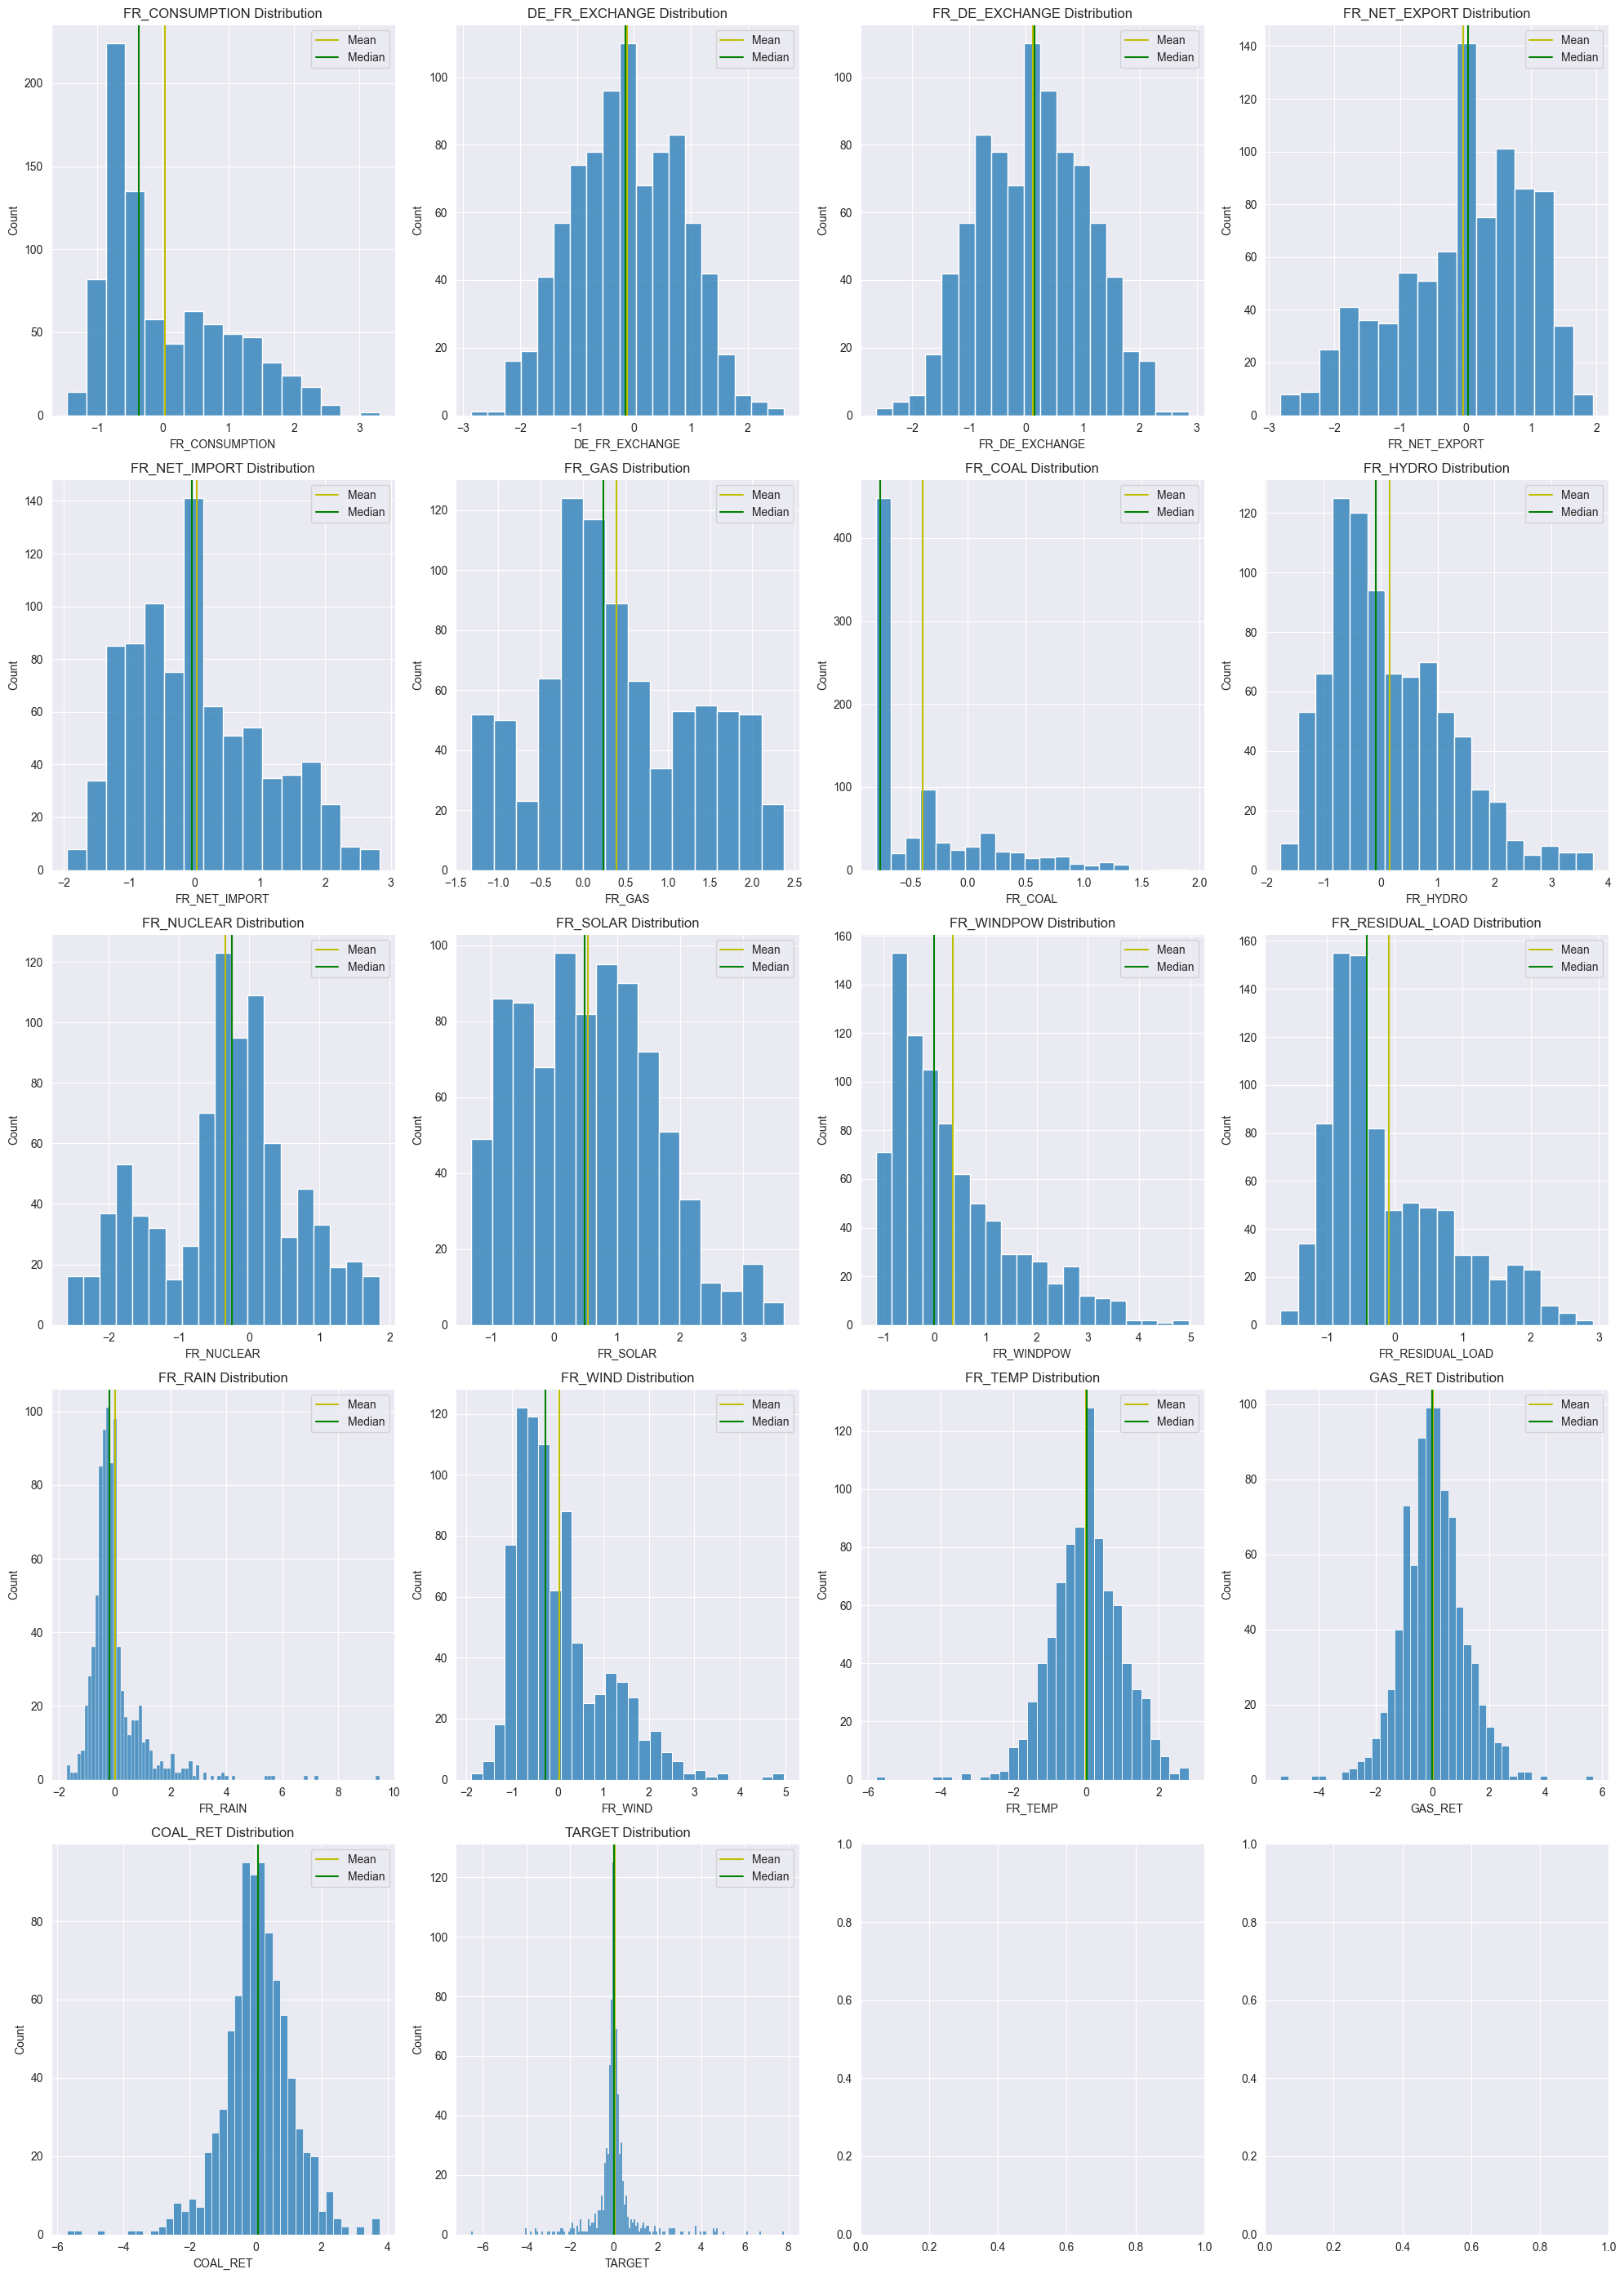

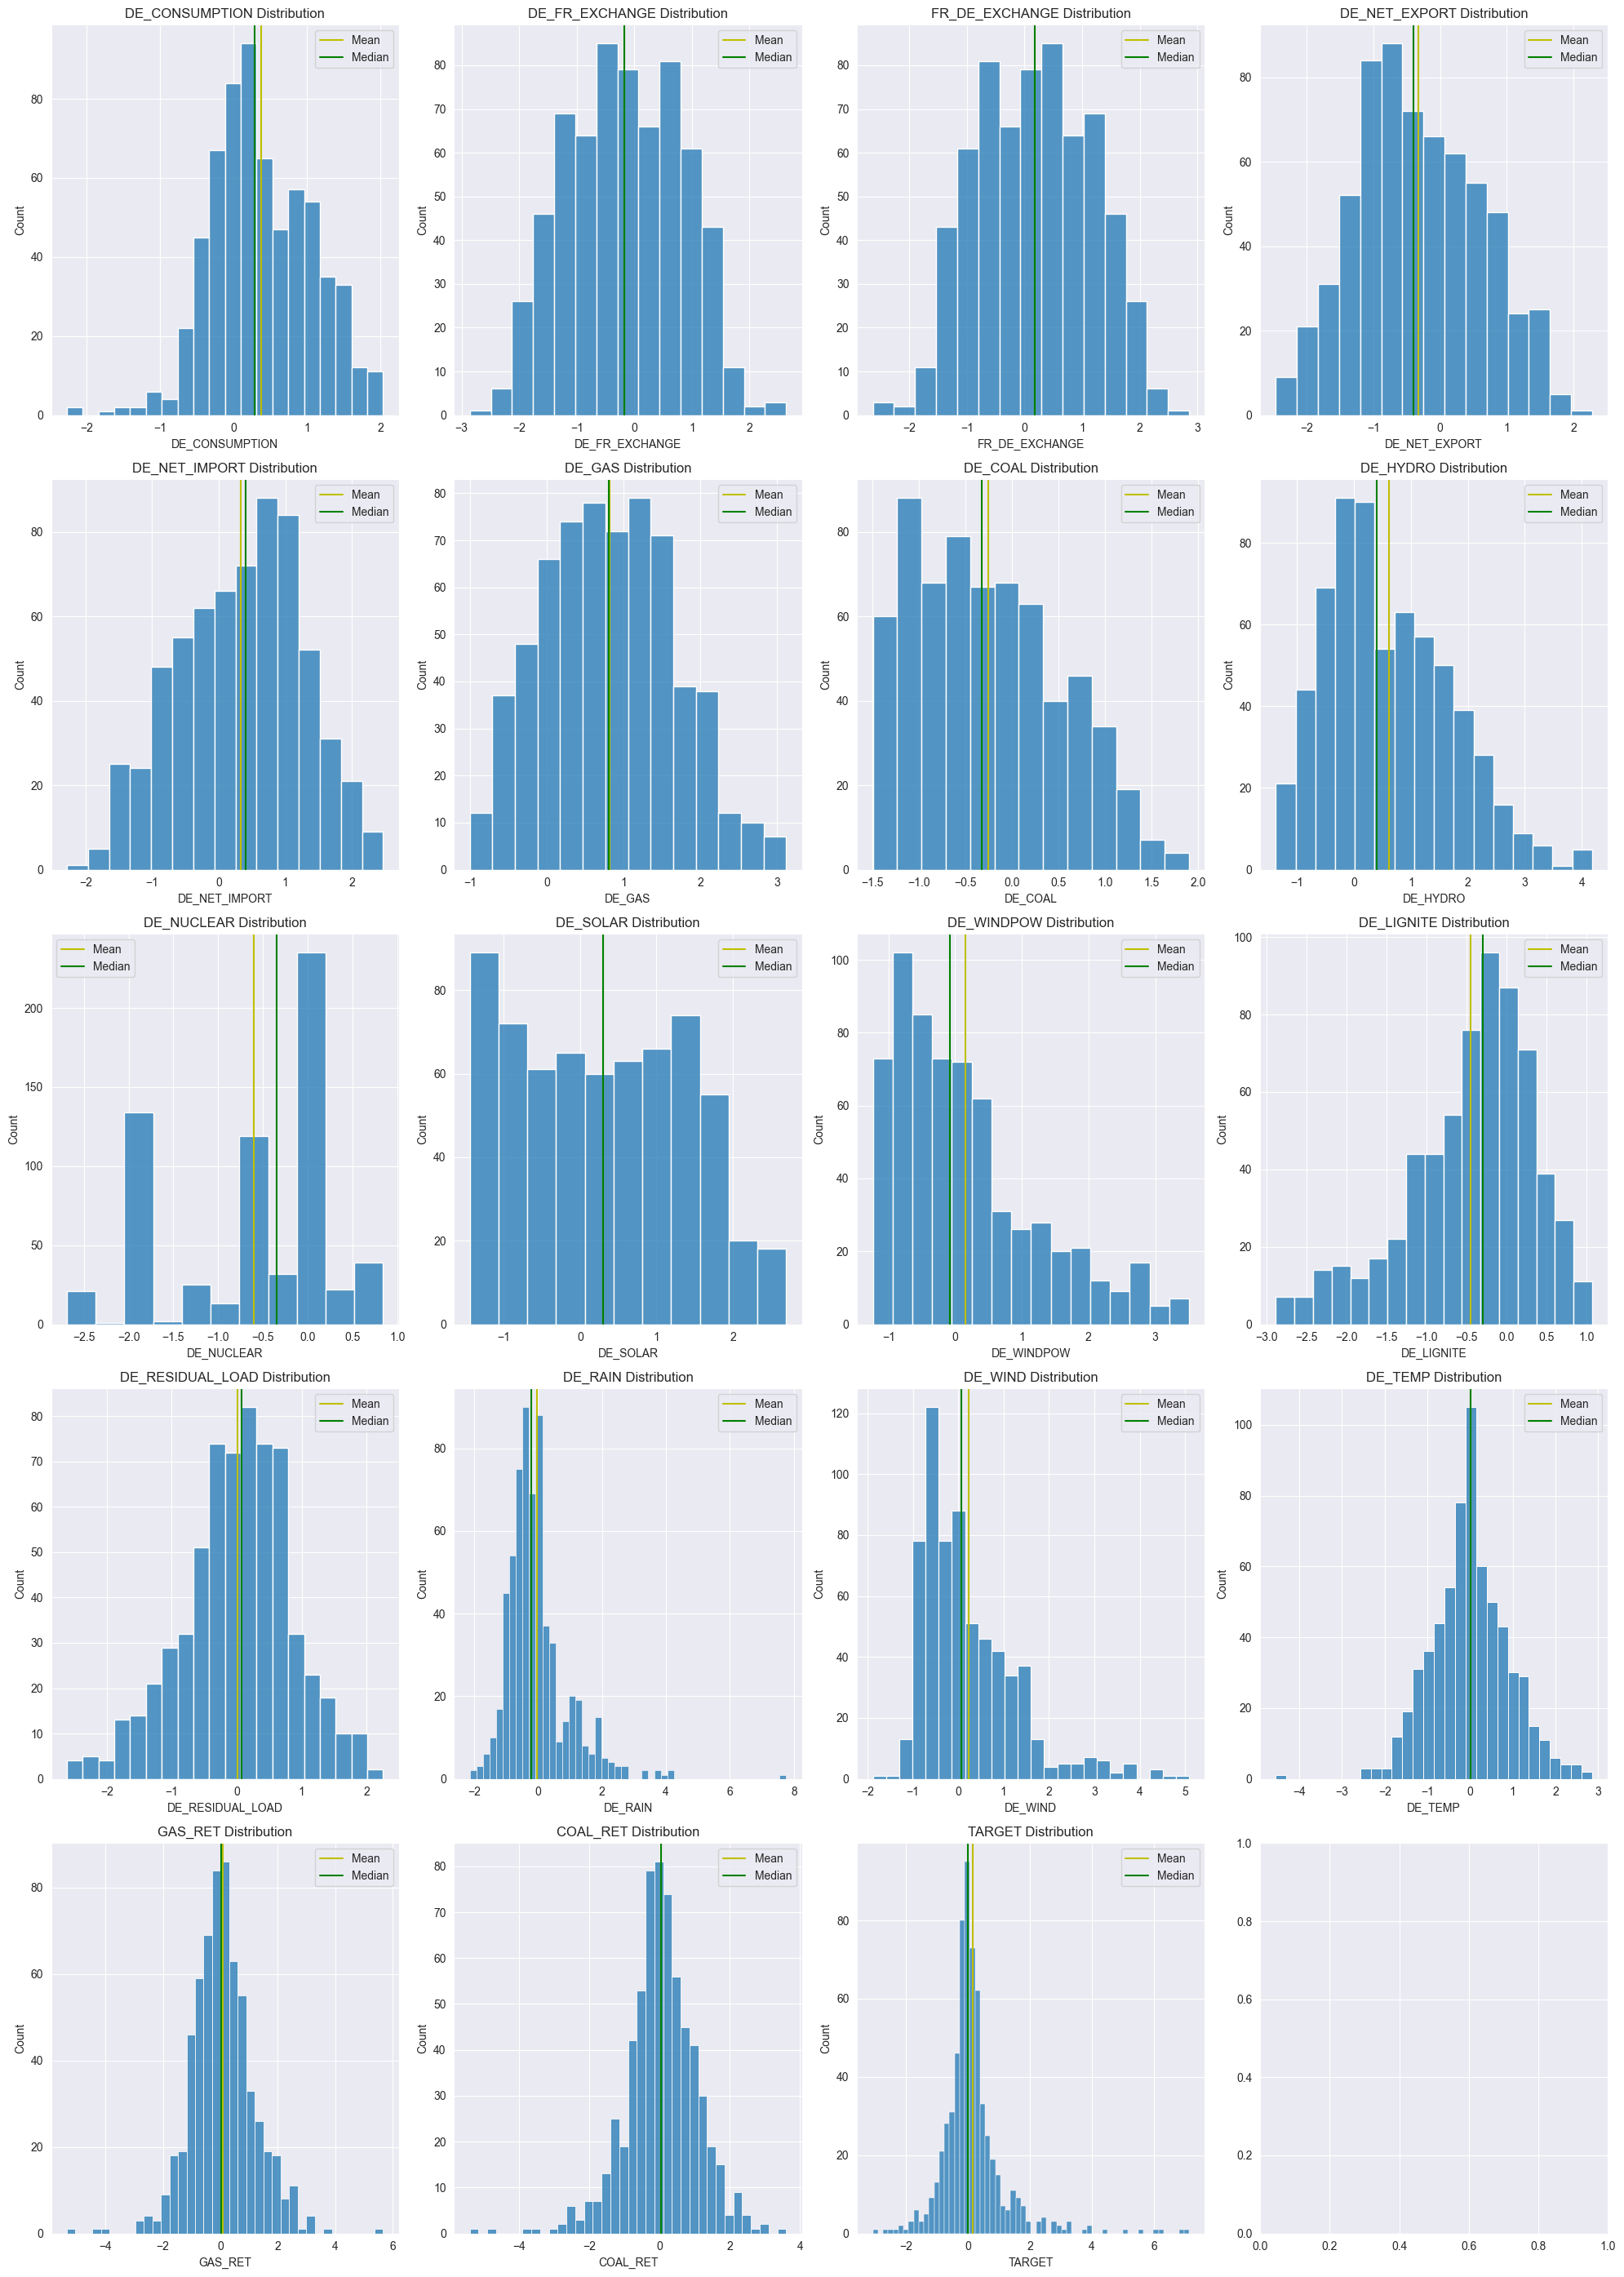

In [296]:
# création des histogrammes
# pour la France
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 28))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

for i, ax in enumerate(axes.flatten()):
    if i < len(data_FR.describe().columns):
        j = data_FR.describe().columns[i]
        sns.histplot(data_FR[j], ax=ax)
        ax.axvline(data_FR[j].mean(), color='y', linestyle='-', label='Mean')
        ax.axvline(data_FR[j].median(), color='g', linestyle='-', label='Median')
        ax.set_xlabel(j)
        ax.set_title(f'{j} Distribution')
        ax.legend()

plt.tight_layout()
plt.show(block=True)

# pour l'Allemagne
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 28))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

for i, ax in enumerate(axes.flatten()):
    if i < len(data_DE.describe().columns):
        j = data_DE.describe().columns[i]
        sns.histplot(data_DE[j], ax=ax)
        ax.axvline(data_DE[j].mean(), color='y', linestyle='-', label='Mean')
        ax.axvline(data_DE[j].median(), color='g', linestyle='-', label='Median')
        ax.set_xlabel(j)
        ax.set_title(f'{j} Distribution')
        ax.legend()

plt.tight_layout()
plt.show(block=True)

On peut remarquer sur les diagrammes de la France :

FR_CONSUMPTION : distribution asymétrique droite
DE_FR_EXCHANGE : distribution asymétrique droite
FR_DE_EXCHANGE : distribution symétrique gauche
FR_NET_EXPORT : distribution asymétrique gauche
FR_NET_IMPORT : distribution asymétrique droite
FR_GAS : distribution asymétrique droite
FR_COAL : distribution asymétrique
FR_HYDRO : distribution asymétrique droite
FR_NUCLEAR : distribution asymétrique gauche
FR_SOLAR : distribution asymétrique droite
FR_WINDPOW : distribution asymétrique droite
FR_RESIDUAL_LOAD : distribution asymétrique droite
FR_RAIN : distribution asymétrique droite
FR_WIND : distribution asymétrique droite
FR_TEMP : distribution symétrique
GAS_RET : distribution asymétrique droite
COAL_RET : distribution asymétrique gauche
TARGET : distribution asymétrique droite

On peut remarquer sur les diagrammes de l'Allemagne :

DE_CONSUMPTION : distribution asymétrique gauche
DE_FR_EXCHANGE : distribution asymétrique droite
FR_DE_EXCHANGE : distribution asymétrique gauche
DE_NET_EXPORT : distribution asymétrique droite
DE_NET_IMPORT : distribution asymétrique gauche
DE_GAS : distribution asymétrique droite
DE_COAL : distribution asymétrique droite
DE_HYDRO : distribution asymétrique droite
DE_NUCLEAR : distribution asymétrique
DE_SOLAR : distribution asymétrique droite
DE_WINDPOW : distribution asymétrique droite
DE_LIGNITE : distribution asymétrique gauche
DE_RESIDUAL_LOAD : distribution asymétrique gauche
DE_RAIN : distribution asymétrique droite
DE_WIND : distribution asymétrique droite
DE_TEMP : distribution asymétrique gauche
GAS_RET : distribution asymétrique droite
COAL_RET : distribution asymétrique gauche
TARGET : distribution asymétrique droite

des diagrammes en boîte :

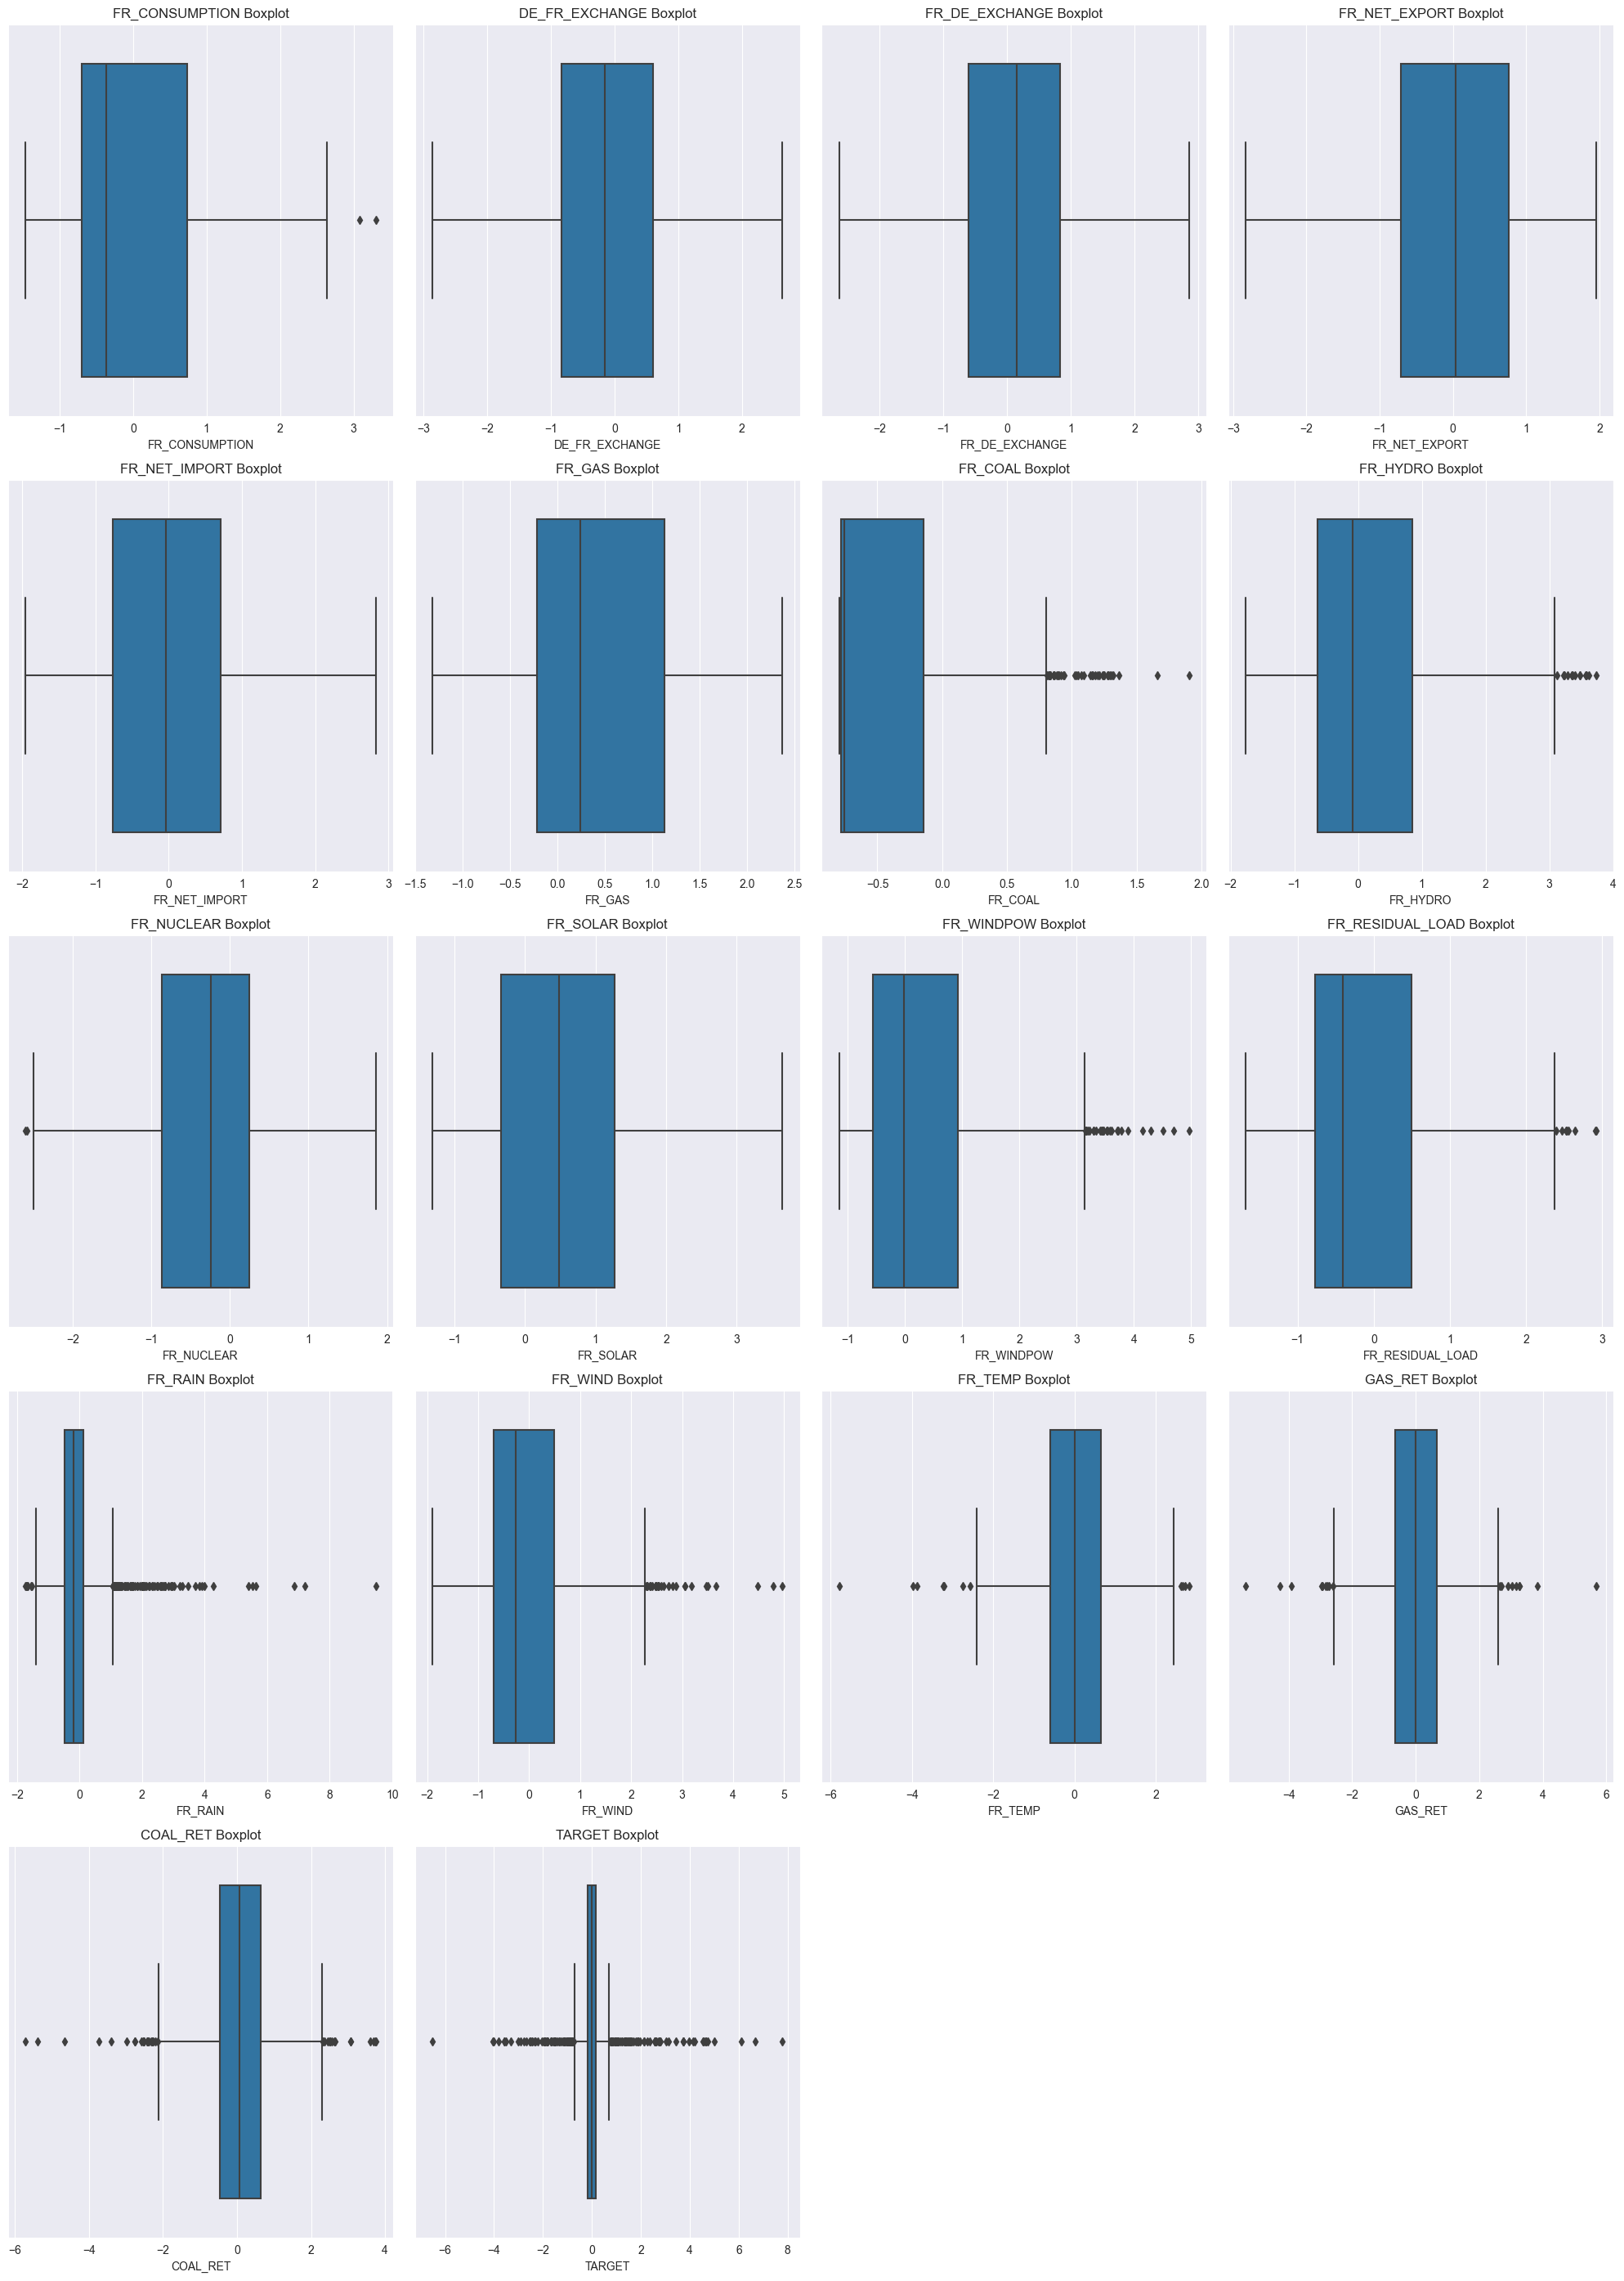

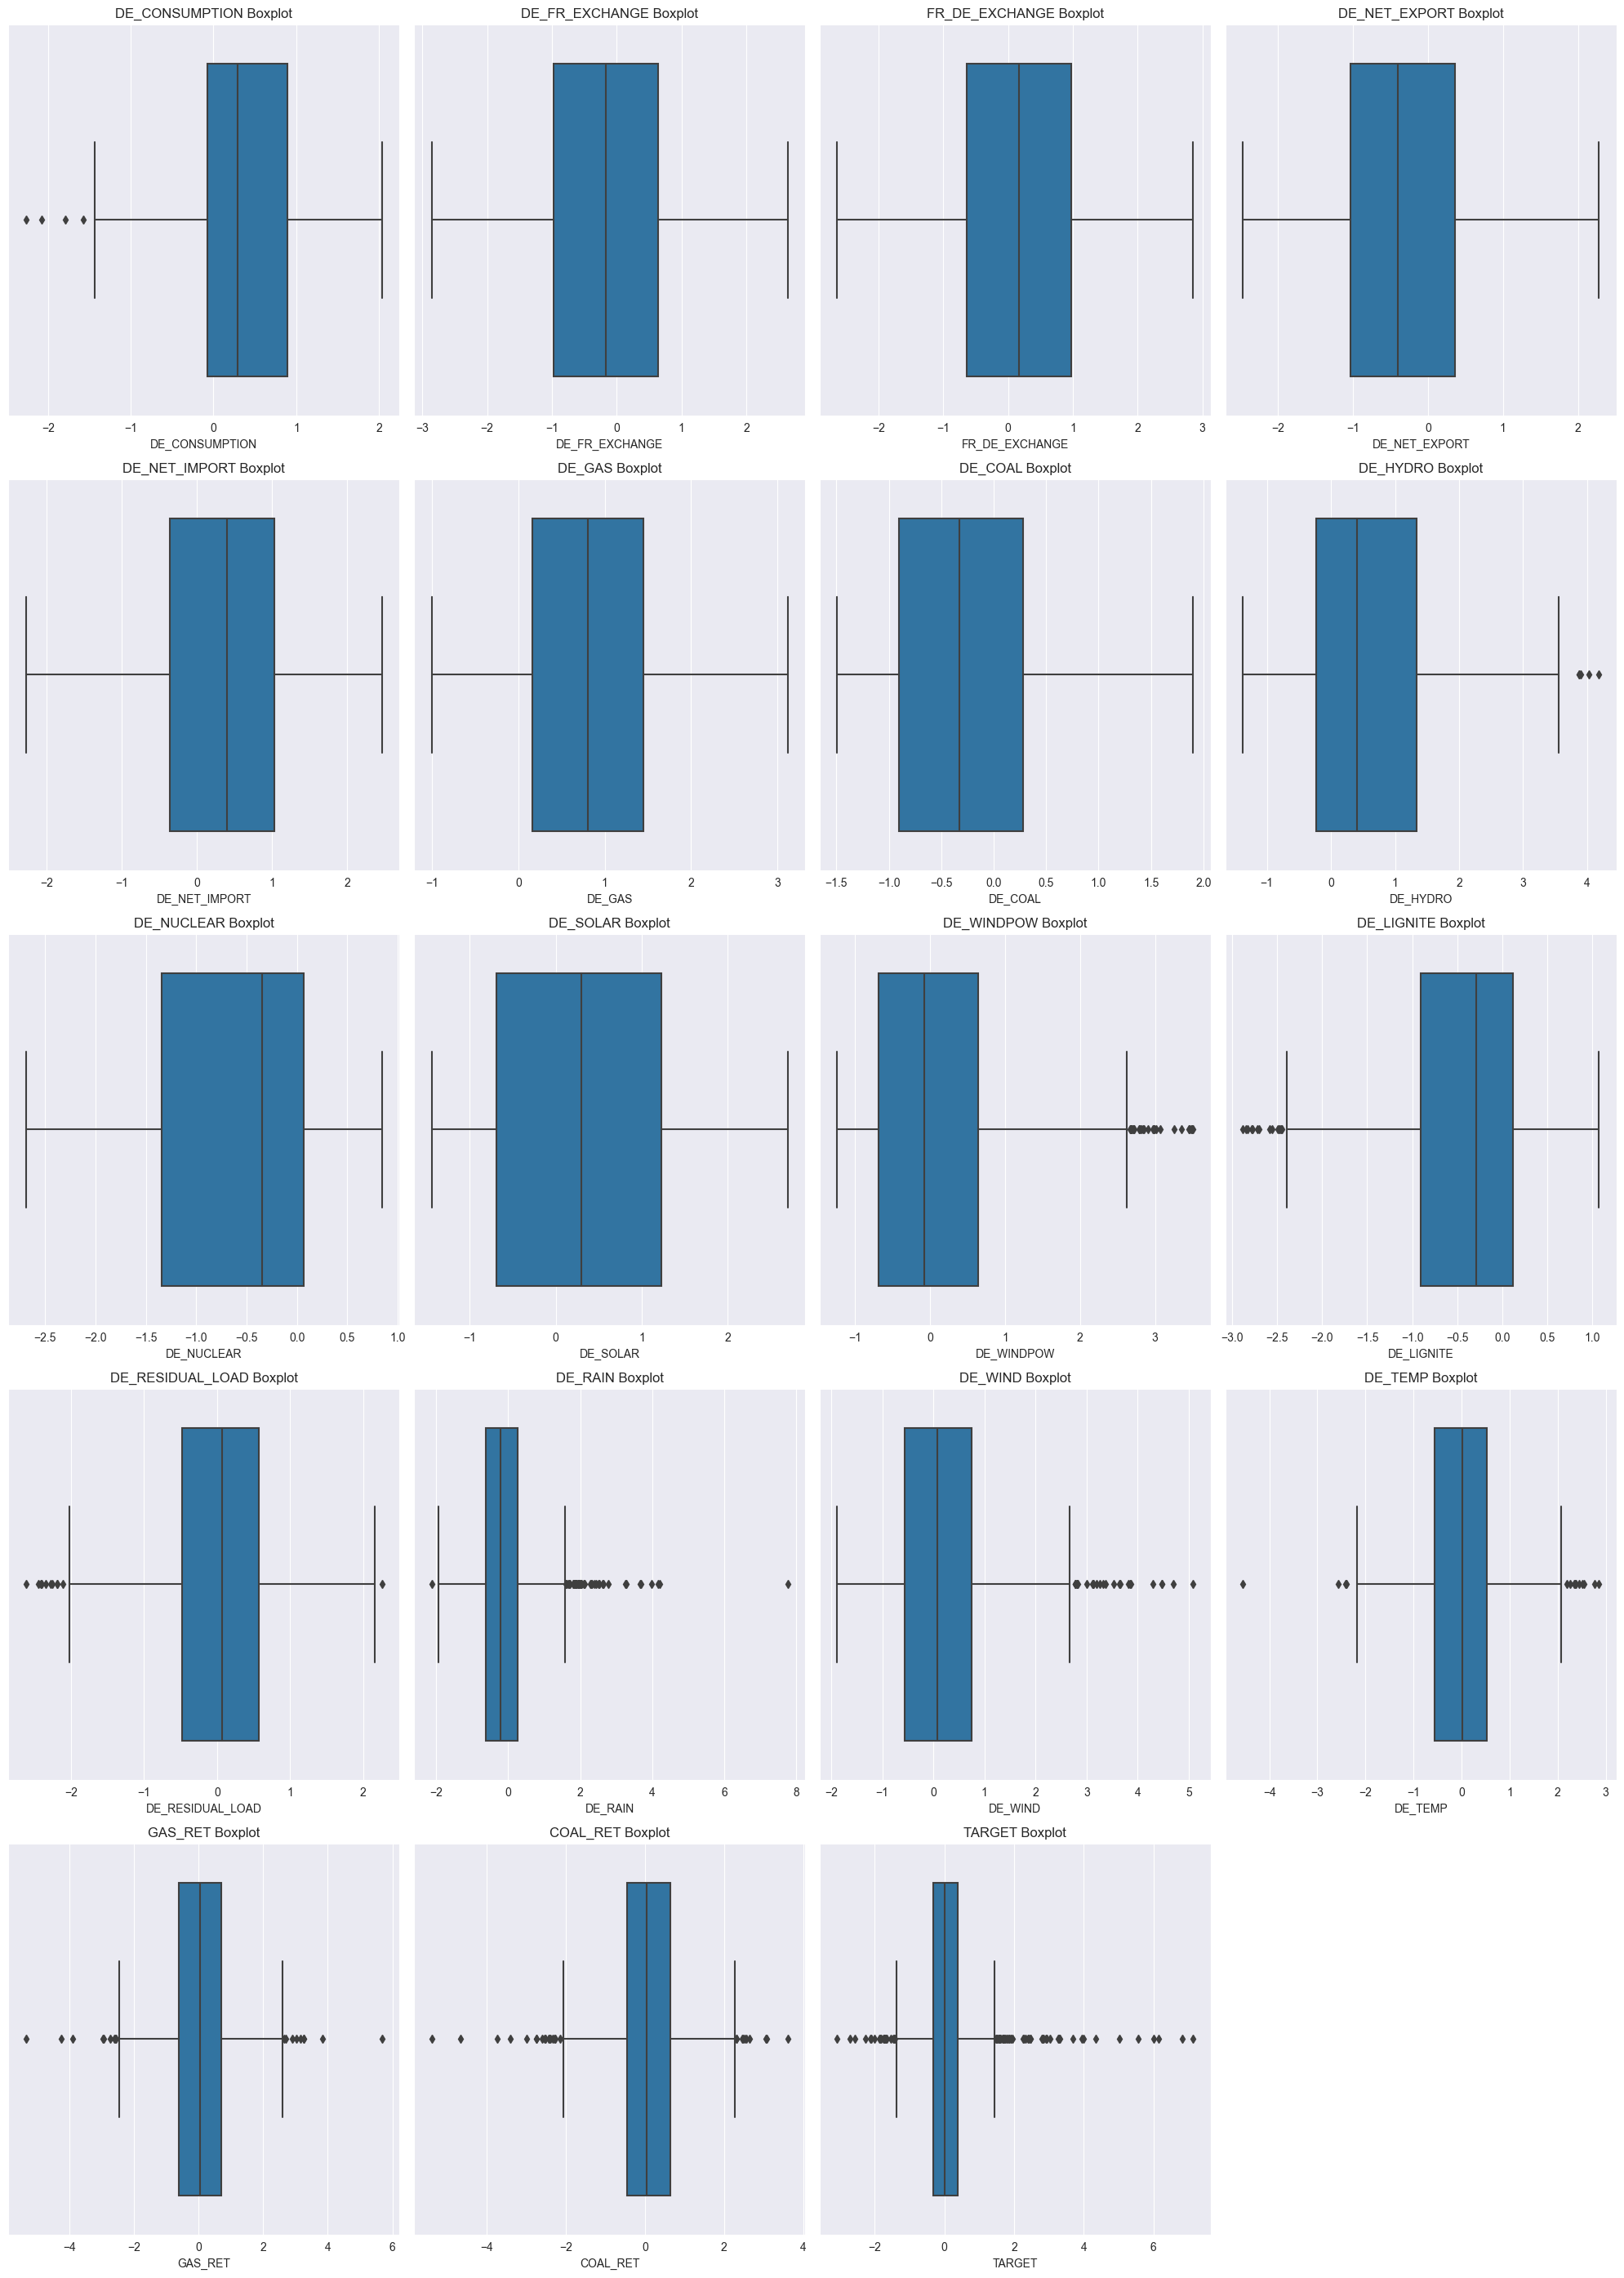

In [297]:
# création de diagrammes en boîtes
# pour la France
plt.figure(figsize=(20, 28))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, j in enumerate(data_FR.describe().columns):
    plt.subplot(5, 4, i+1)
    sns.boxplot(x=data_FR[j])
    plt.title('{} Boxplot'.format(j))

plt.tight_layout()
plt.show()

# pour l'Allemagne
plt.figure(figsize=(20, 28))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, j in enumerate(data_DE.describe().columns):
    plt.subplot(5, 4, i+1)
    sns.boxplot(x=data_DE[j])
    plt.title('{} Boxplot'.format(j))

plt.tight_layout()
plt.show()

On remarque que FR_CONSUMPTION, FR_COAL, FR_HYDRO, FR_WINDPOW, FR_RESIDUAL_LOAD, FR_RAIN, FR_WIND, FR_TEMP, GAS_RET, COAL_RET, TARGET possèdent de nombreuses valeurs aberrantes.

On remarque que DE_CONSUMPTION, DE_HYDRO, DE_WINDPOW, DE_LIGNITE, DE_RESIDUAL_LOAD, DE_RAIN, DE_WIND, DE_TEMP, GAS_RET, COAL_RET, TARGET possèdent de nombreuses valeurs aberrantes.

 et des graphiques de dispersion :

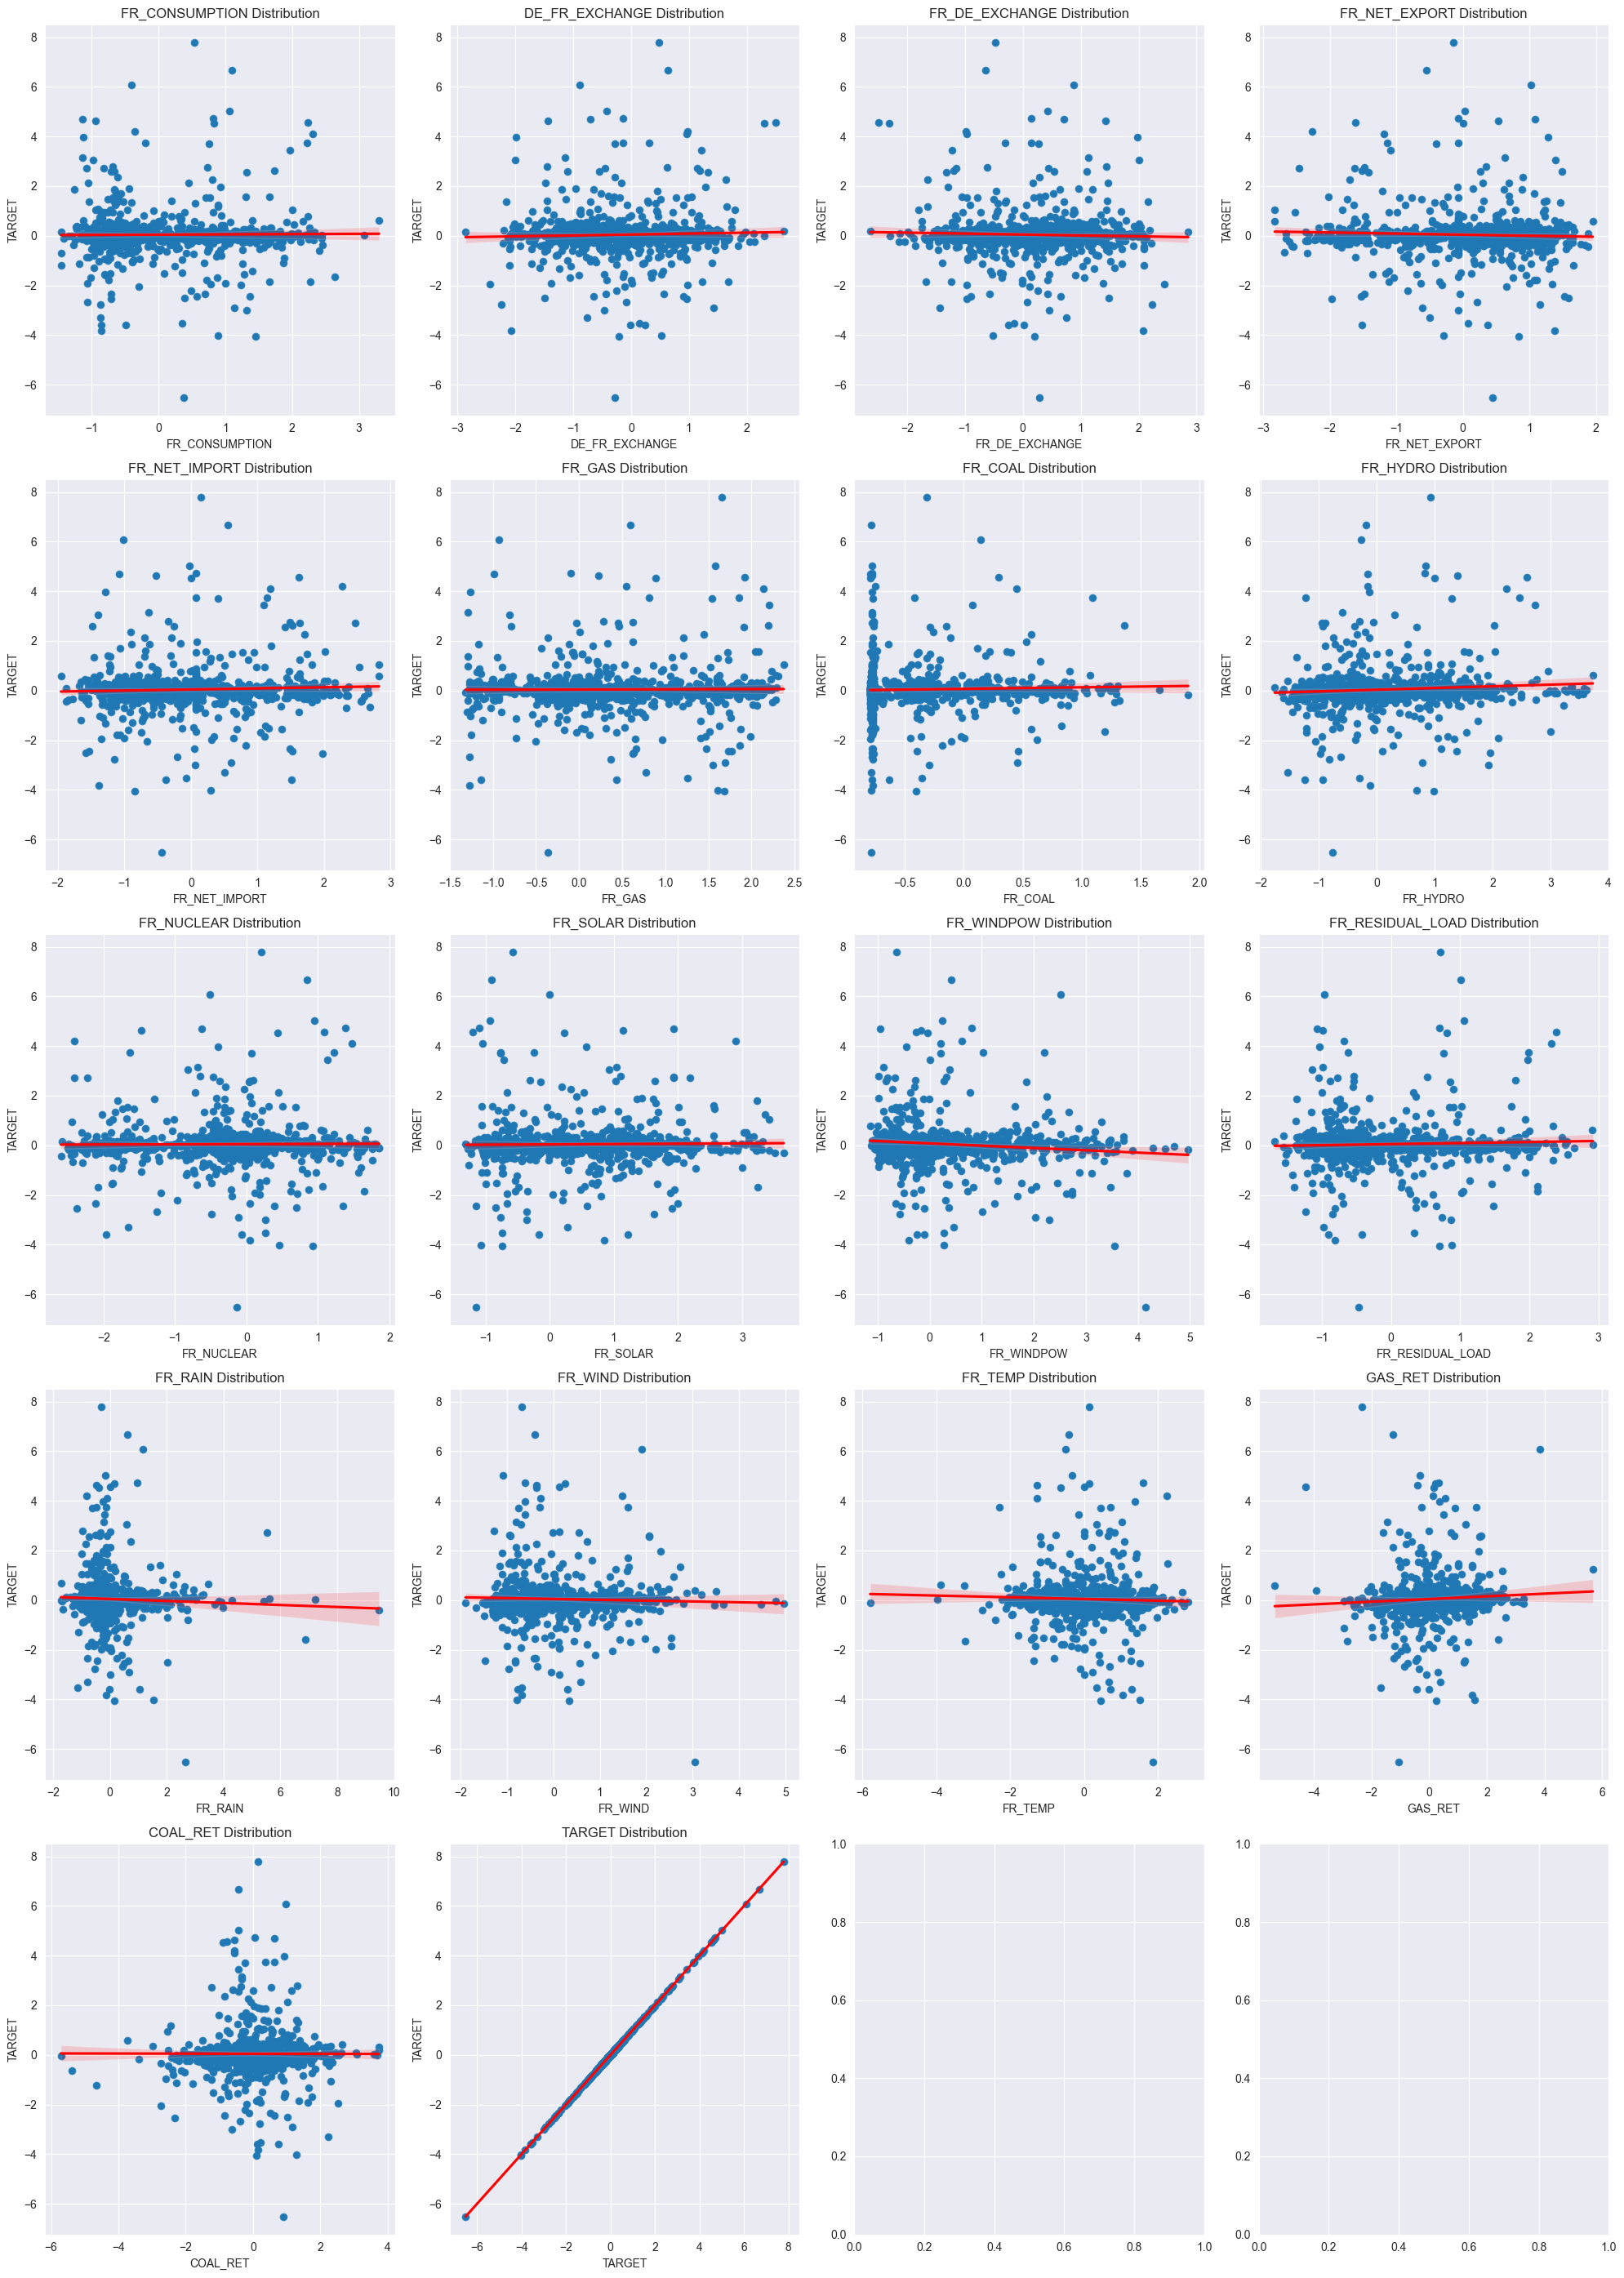

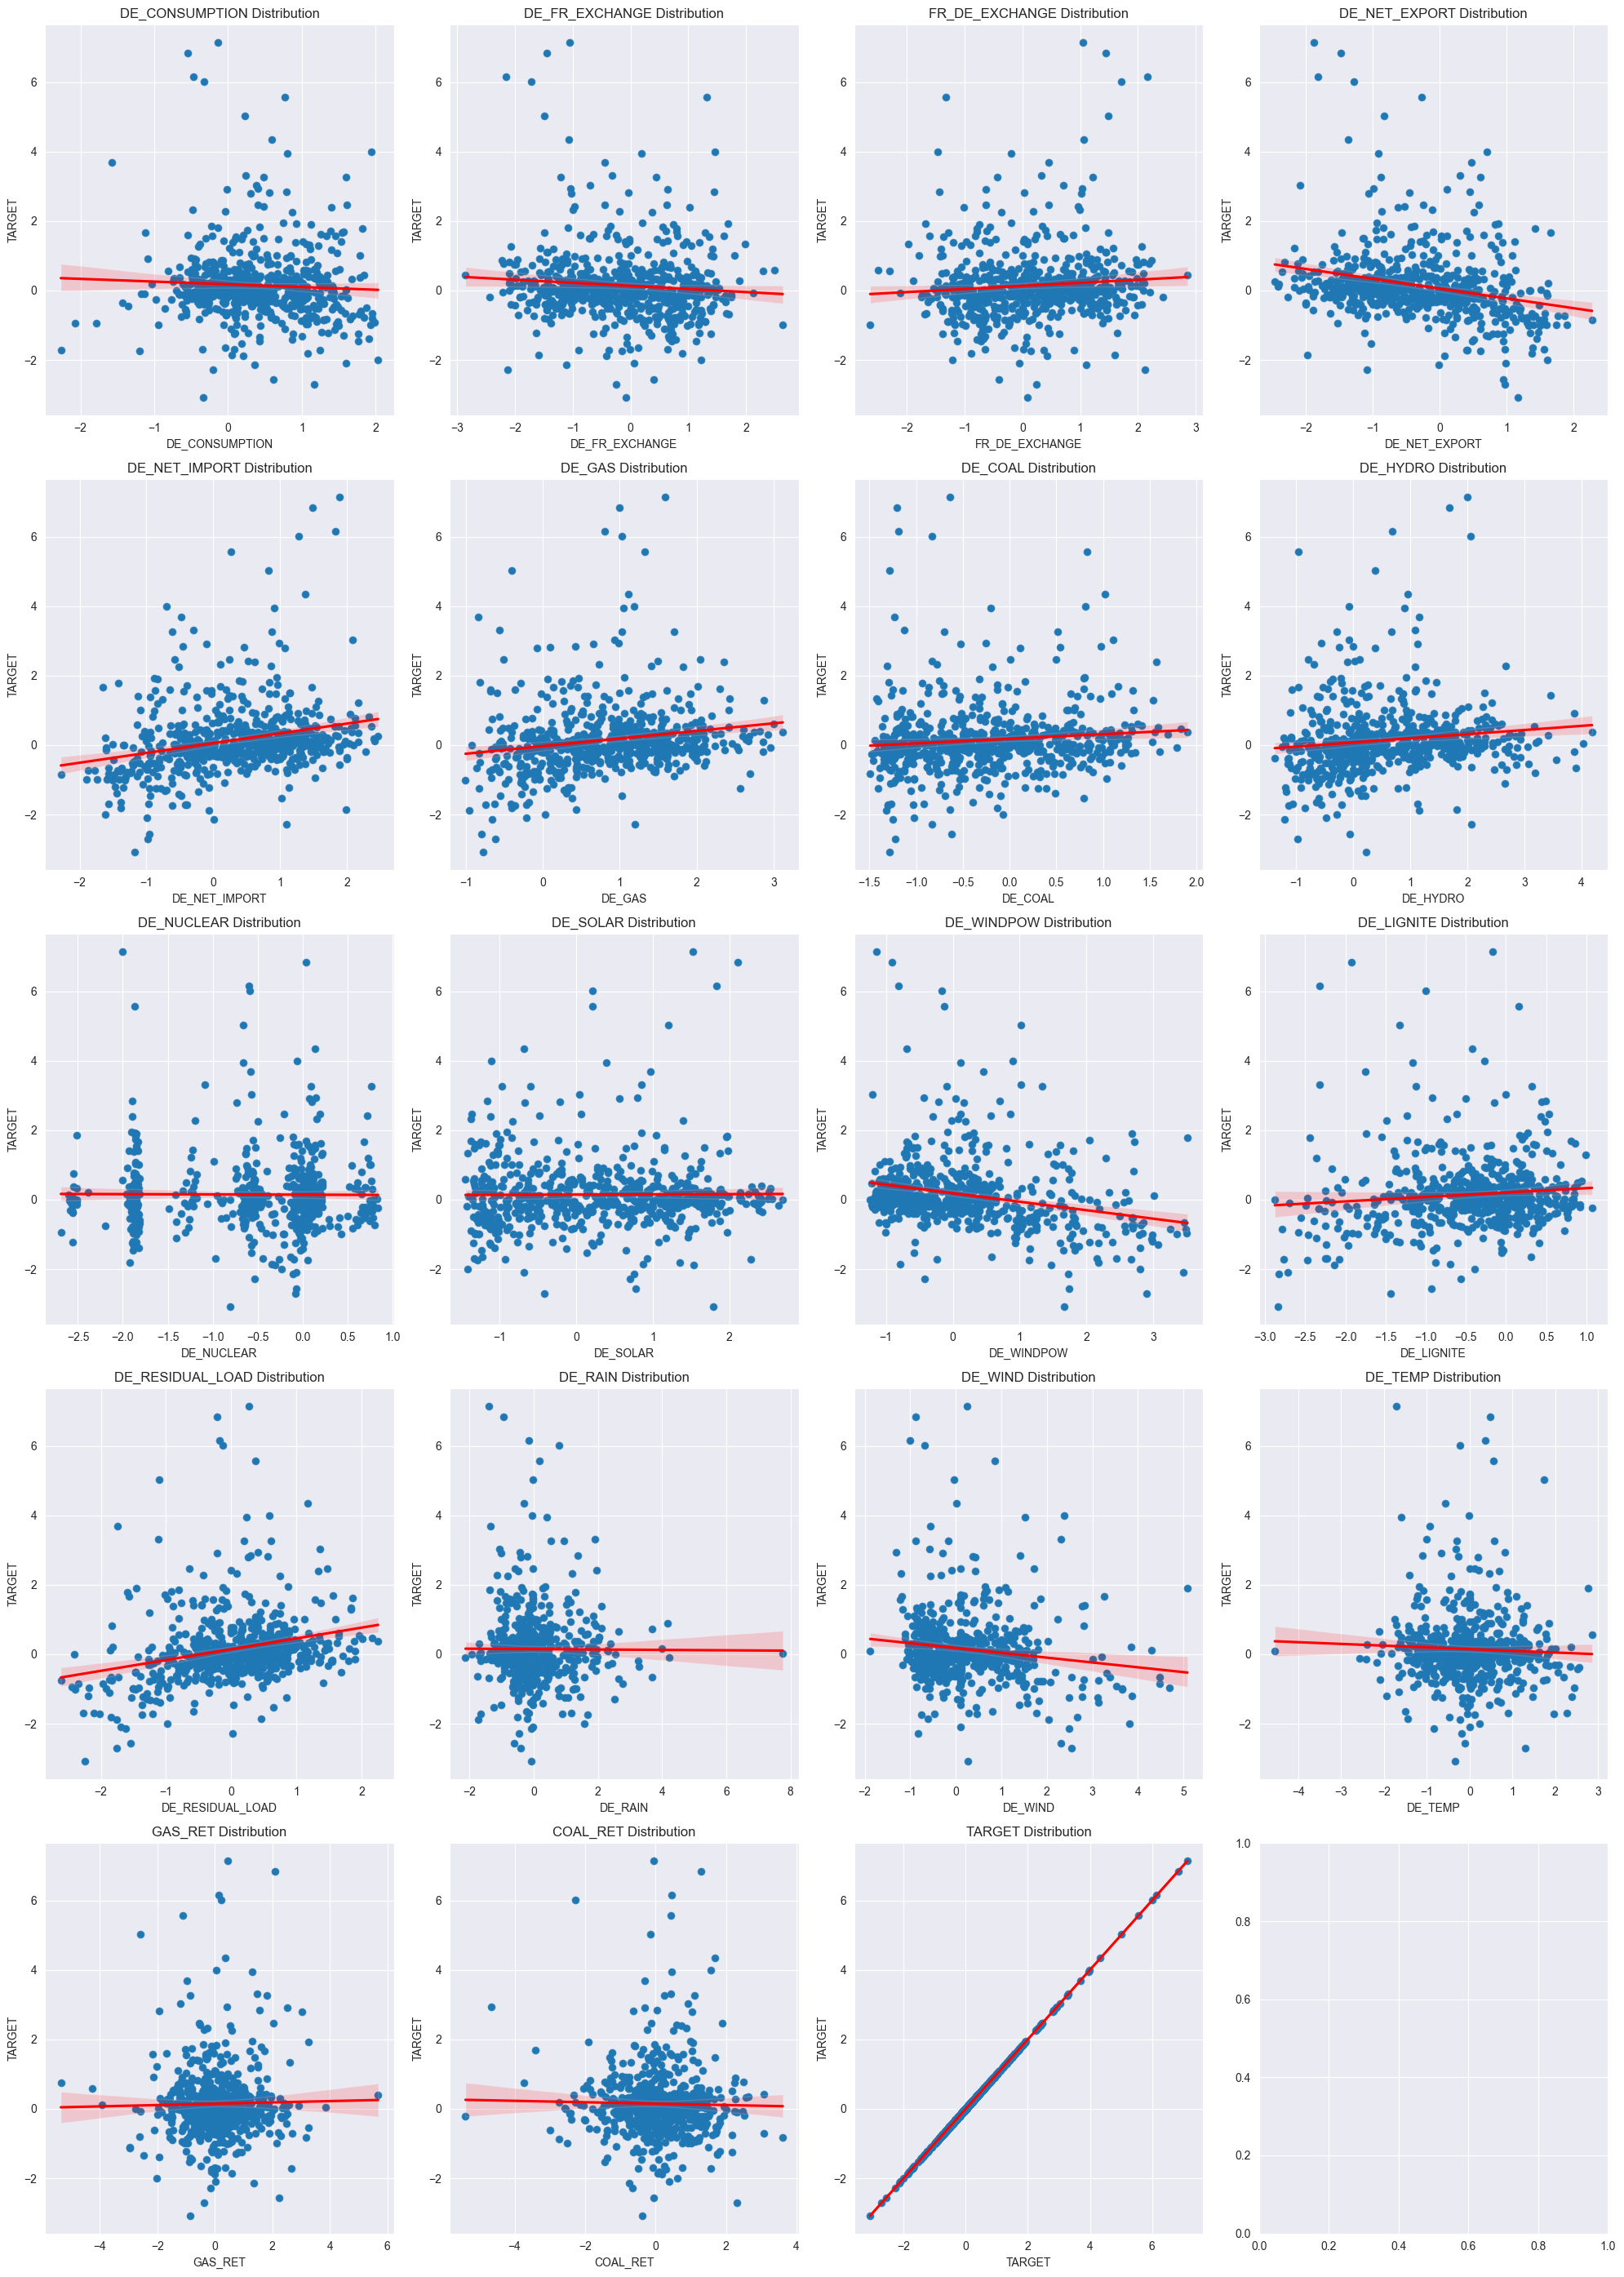

In [298]:
# création de diagrammes de dispersion
# pour la France
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 28))
for i, j in enumerate(data_FR.describe().columns):
    axes.flat[i].set_xlabel(j)
    sns.scatterplot(x=data_FR[j], y=data_FR.TARGET, ax=axes.flat[i])
    axes.flat[i].set_title(f'{j} Distribution')
    sns.regplot(x=data_FR[j], y=data_FR.TARGET, ax=axes.flat[i], line_kws={"color": "red"})

plt.tight_layout()
plt.show(block=True)

# pour l'Allemagne
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 28))
for i, j in enumerate(data_DE.describe().columns):
    axes.flat[i].set_xlabel(j)
    sns.scatterplot(x=data_DE[j], y=data_DE.TARGET, ax=axes.flat[i])
    axes.flat[i].set_title(f'{j} Distribution')
    sns.regplot(x=data_DE[j], y=data_DE.TARGET, ax=axes.flat[i], line_kws={"color": "red"})

plt.tight_layout()
plt.show(block=True)

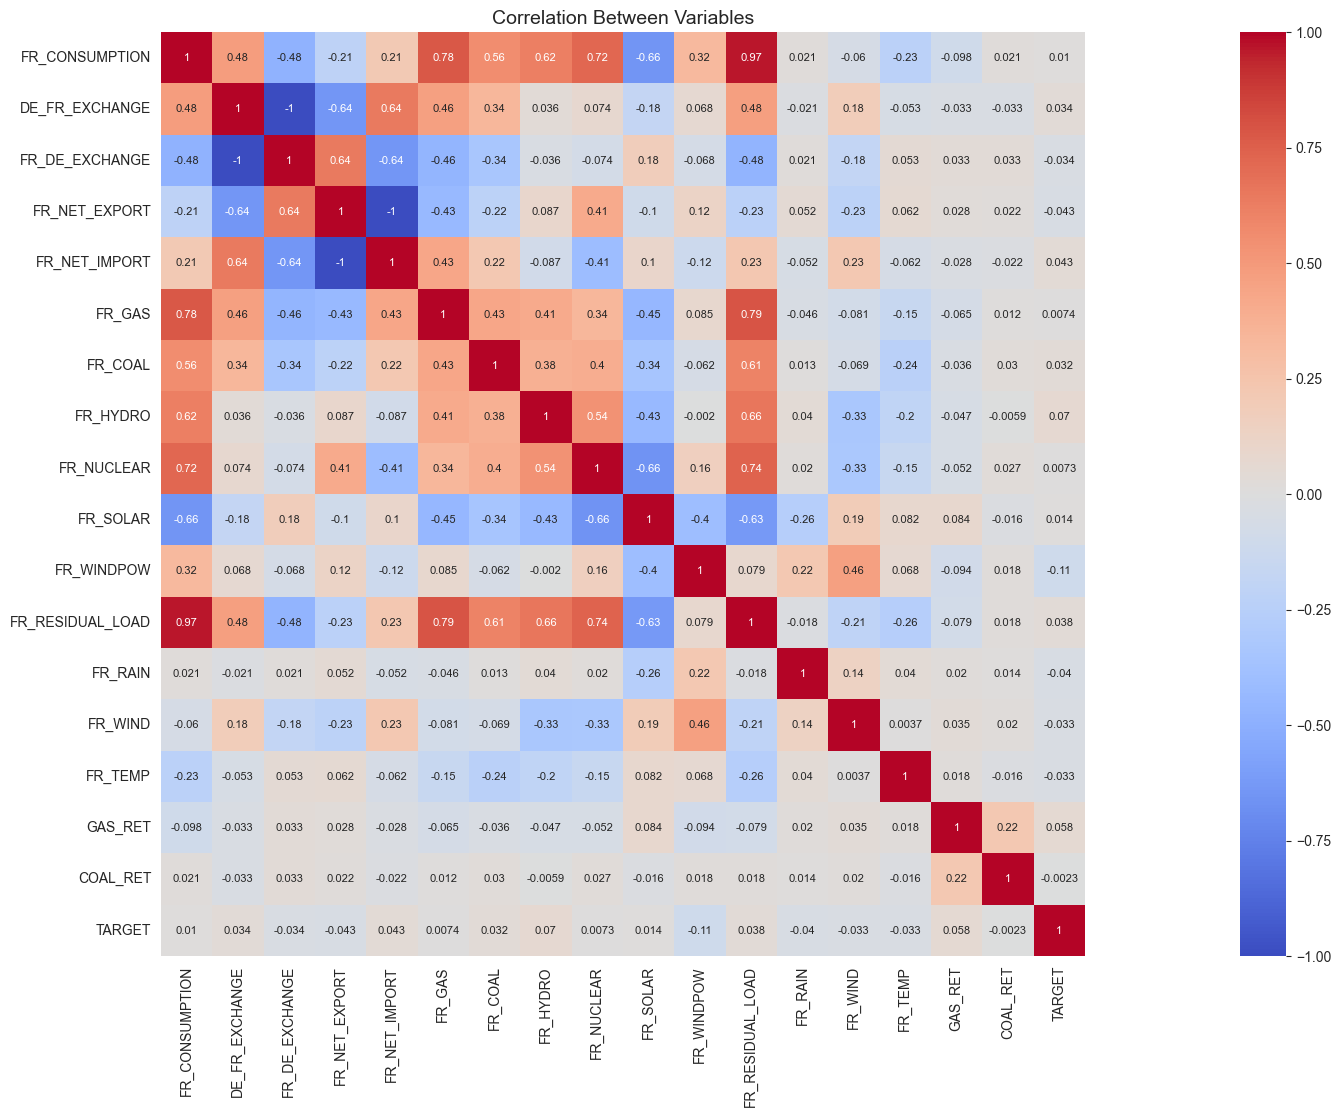

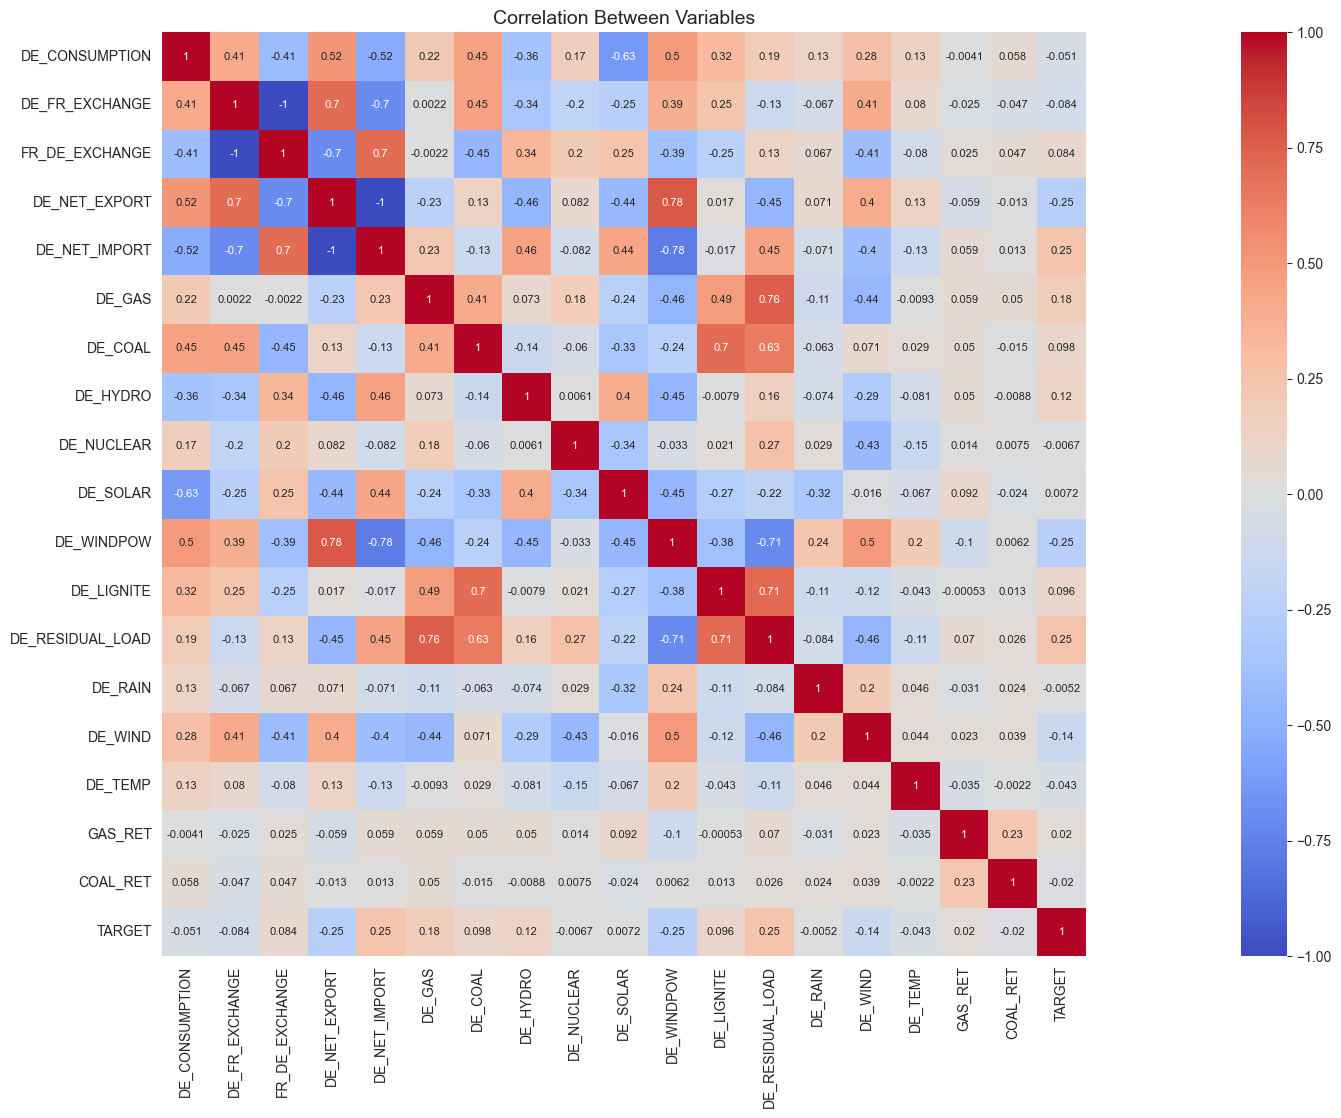

In [299]:
# Calculer la matrice de corrélation
# pour la France
correlation_metrics_1 = data_FR.corr()

# pour l'Allemagne
correlation_metrics_2 = data_DE.corr()

# Créer la heatmap avec une taille plus grande, une police plus petite et une palette de couleurs adaptée
# pour la France
fig1 = plt.figure(figsize=(40, 12))
sns.heatmap(correlation_metrics_1, square=True, annot=True, annot_kws={"size": 8}, vmax=1, vmin=-1, cmap='coolwarm')
plt.title('Correlation Between Variables', size=14)
plt.show()

# pour l'Allemagne
fig2 = plt.figure(figsize=(40, 12))
sns.heatmap(correlation_metrics_2, square=True, annot=True, annot_kws={"size": 8}, vmax=1, vmin=-1, cmap='coolwarm')
plt.title('Correlation Between Variables', size=14)
plt.show()

Pour la France, on aperçoit de très forte corrélation entre FR_NET_EXPORT et FR_DE_EXCHANGE (0.64), FR_NET_IMPORT et DE_FR_EXCHANGE (0.64), FR_GAS et FR_CONSUMPTION (0.78), FR_HYDRO et FR_CONSUMPTION (0.62), FR_NUCLEAR et FR_CONSUMPTION (0.72), FR_RESIDUAL_LOAD et FR_CONSUMPTION (0.97).

Au niveau des corrélations des variables et TARGET, nous en avons très peu les plus grandes sont :

-FR_HYDRO et TARGET (0.07)
-GAS_RET et TARGET (0.58)
-FR_NET_IMPORT et TARGET (0.043)
-FR_RESIDUAL_LOAD et TARGET (0.038)
-DE_FR_EXCHANGE et TARGET (0.034)
-FR_COAL et TARGET (0.032)
-FR_WIND et TARGET (-0.033)
-FR_TEMP et TARGET (-0.033)
-FR_DE_EXCHANGE et TARGET (-0.034)
-FR_RAIN et TARGET (-0.04)
-FR_NET_EXPORT et TARGET (-0.043)
-FR_WINDPOW et TARGET (-0.11)

Pour l'Allemagne, on s'aperçoit que les corrélations ne sont pas fortes, mais il y a quelque variables qui possèdent des corrélations positives plus grandes que 0 entre les différentes variables et TARGET tels que :

-DE_NET_IMPORT et TARGET (0.25)
-DE_RESIDUAL_LOAD et TARGET (0.25)
-DE_GAS et TARGET (0.18)
-DE_HYDRO et TARGET (0.12)
-DE_COAL et TARGET (0.098)
-DE_LIGNITE et TARGET (0.096)
-DE_WIND et TARGET (-0.14)
-DE_NET_EXPORT et TARGET (-0.25)
-DE_WINDPOW et TARGET (-0.25)

Sinon, on aperçoit de très forte corrélation entre DE_NET_EXPORT et DE_FR_EXCHANGE (0.7), DE_NET_IMPORT et FR_DE_EXCHANGE (0.7), DE_WINDPOW et DE_NET_EXPORT (0.78), DE_LIGNITE et DE_COAL (0.7), DE_RESIDUAL_LOAD et DE_GAS (0.76).

Afin de préparer nos données pour effectuer la modélisation de données, nous allons choisir les variables que nous voulons par rapport aux corrélations entre les variables et TARGET. Nous allons prendre pour la France un seuil minimum de corrélation égale à 0.04 et pour l'Allemagne, 0.1. Ensuite, nous nous sommes demandés s'il était avantageux de supprimer les valeurs aberrantes ou non. Après, plusieurs tests, nous nous sommes rendus compte qu'il était préférable de garder les valeurs aberrantes, car sinon nous faussions nos tests par manque de données.

C) Modélisation des données

La régression linéaire est une méthode de machine learning pour trouver la relation entre une variable appelée la variable dépendante (ou la variable cible) et une ou plusieurs variables appelées les variables indépendantes (ou les variables explicatives). Cette méthode suppose que la relation entre les variables est linéaire, c'est-à-dire que la variable dépendante peut être exprimée comme une combinaison linéaire des variables indépendantes.

Le but de la régression linéaire est de trouver la droite qui représente au mieux la relation entre les variables.

Inertie intra-cluster : 3722.05
Indice de silhouette : 0.23
Indice de Calinski-Harabasz : 230.30
Indice de Davies-Bouldin : 1.56
Score du modèle de régression : 3.28%


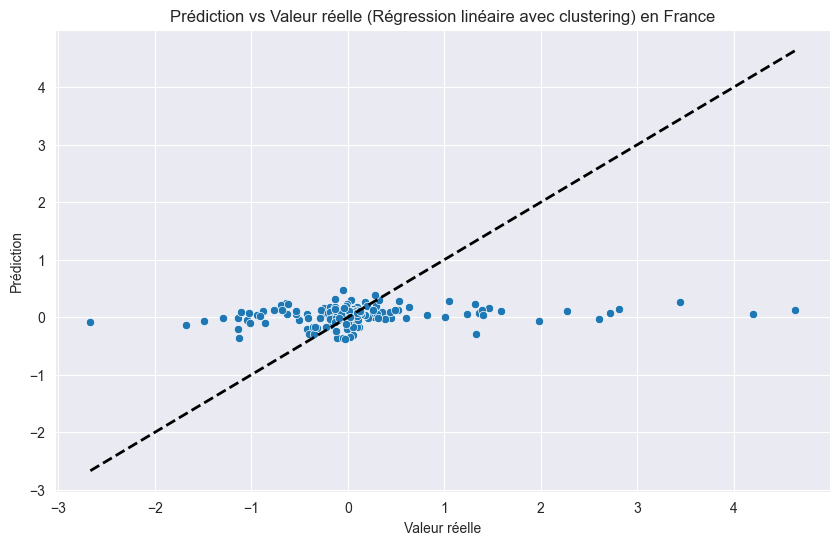

MSE : 0.76
RMSE : 0.87
R^2 : 0.03


Inertie intra-cluster : 2103.25
Indice de silhouette : 0.25
Indice de Calinski-Harabasz : 322.83
Indice de Davies-Bouldin : 1.37
Score du modèle de régression : 11.47%


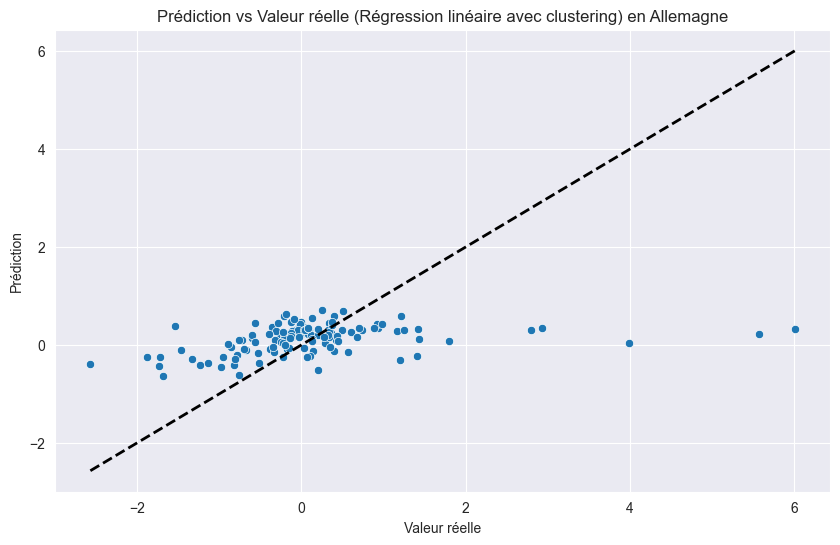

MSE : 1.11
RMSE : 1.05
R^2 : 0.11


In [300]:
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# sélectionne les variables qui nous intéressent
data_FR = data_FR.filter(regex='FR_NET_EXPORT|FR_WINDPOW|FR_RAIN|FR_NET_IMPORT|FR_HYDRO|GAS_RET|TARGET', axis=1)
data_DE = data_DE.filter(regex='DE_NET_EXPORT|DE_WINDPOW|DE_NET_IMPORT|DE_GAS|DE_HYDRO|DE_RESIDUAL_LOAD|DE_WIND|TARGET', axis=1)

# REGRESSION LINEAIRE

# pour la France
# Création des clusters
X_cluster = data_FR.drop('TARGET', axis=1)
Y = data_FR.filter(regex='TARGET', axis=1)
kmeans_model = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_model.fit(X_cluster)
cluster_labels = kmeans_model.labels_
data_FR['Cluster'] = cluster_labels

inertia = kmeans_model.inertia_
print("Inertie intra-cluster : {:.2f}".format(inertia))
silhouette_avg = silhouette_score(X_cluster, cluster_labels)
print("Indice de silhouette : {:.2f}".format(silhouette_avg))
calinski_score = calinski_harabasz_score(X_cluster, cluster_labels)
print("Indice de Calinski-Harabasz : {:.2f}".format(calinski_score))
davies_score = davies_bouldin_score(X_cluster, cluster_labels)
print("Indice de Davies-Bouldin : {:.2f}".format(davies_score))

# Régression Linéaire avec clusters

X_train, X_test, Y_train, Y_test = train_test_split(X_cluster, Y, test_size=0.2, random_state=42)
X_train['Cluster'] = data_FR.loc[X_train.index, 'Cluster']
X_test['Cluster'] = data_FR.loc[X_test.index, 'Cluster']

regression_model = LinearRegression()
regression_model.fit(X_train, Y_train)
Y_pred = regression_model.predict(X_test)
accuracy = regression_model.score(X_test, Y_test)
print("Score du modèle de régression : {:.2f}%".format(accuracy * 100))

plt.figure(figsize=(10, 6))
sns.scatterplot(x=Y_test.values.flatten(), y=Y_pred.flatten())
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
plt.xlabel('Valeur réelle')
plt.ylabel('Prédiction')
plt.title('Prédiction vs Valeur réelle (Régression linéaire avec clustering) en France')
plt.show()

mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print("MSE : {:.2f}".format(mse))
print("RMSE : {:.2f}".format(rmse))
print("R^2 : {:.2f}\n\n".format(r2))


# pour l'Allemagne
# Création des clusters
X_cluster = data_DE.drop('TARGET', axis=1)
Y = data_DE.filter(regex='TARGET', axis=1)
kmeans_model = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_model.fit(X_cluster)
cluster_labels = kmeans_model.labels_
data_DE['Cluster'] = cluster_labels

inertia = kmeans_model.inertia_
print("Inertie intra-cluster : {:.2f}".format(inertia))
silhouette_avg = silhouette_score(X_cluster, cluster_labels)
print("Indice de silhouette : {:.2f}".format(silhouette_avg))
calinski_score = calinski_harabasz_score(X_cluster, cluster_labels)
print("Indice de Calinski-Harabasz : {:.2f}".format(calinski_score))
davies_score = davies_bouldin_score(X_cluster, cluster_labels)
print("Indice de Davies-Bouldin : {:.2f}".format(davies_score))

# Régression Linéaire avec clusters

X_train, X_test, Y_train, Y_test = train_test_split(X_cluster, Y, test_size=0.2, random_state=42)
X_train['Cluster'] = data_DE.loc[X_train.index, 'Cluster']
X_test['Cluster'] = data_DE.loc[X_test.index, 'Cluster']

regression_model = LinearRegression()
regression_model.fit(X_train, Y_train)
Y_pred = regression_model.predict(X_test)
accuracy = regression_model.score(X_test, Y_test)
print("Score du modèle de régression : {:.2f}%".format(accuracy * 100))

plt.figure(figsize=(10, 6))
sns.scatterplot(x=Y_test.values.flatten(), y=Y_pred.flatten())
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
plt.xlabel('Valeur réelle')
plt.ylabel('Prédiction')
plt.title('Prédiction vs Valeur réelle (Régression linéaire avec clustering) en Allemagne')
plt.show()

mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print("MSE : {:.2f}".format(mse))
print("RMSE : {:.2f}".format(rmse))
print("R^2 : {:.2f}".format(r2))

La régression ridge est une méthode de régression linéaire qui vise à réduire la variance du modèle en ajoutant une pénalité (appelée régularisation) aux coefficients de régression. Cette pénalité est contrôlée par un hyperparamètre appelé alpha, qui peut être ajusté pour trouver le meilleur compromis entre ajustement aux données et généralisation à de nouvelles données.

En ajoutant une pénalité aux coefficients, la régression ridge peut réduire le risque d'overfitting, c'est-à-dire le risque de créer un modèle qui est trop complexe et qui s'adapte trop étroitement aux données d'entraînement. Cela peut améliorer les performances de prédiction du modèle sur de nouvelles données.

Afin de savoir quel alpha prendre lors des algorithmes de régression linéaire régularisée, on crée un algorithme qui va tester l'algorithme ridge sur différentes valeurs d'alpha.

In [302]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# RECHERCHE D'ALPHA

# pour la France
# Séparation des features (X) de la target (y)
X = data_FR.iloc[:, :-1].values
y = data_FR.iloc[:, -1].values

# Normalisation des features en utilisant StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split du dataset en jeu d'entraînement et jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Régression Ridge avec différentes valeurs d'alpha
for alpha in [0.01, 0.1, 1.0, 10.0, 15.0, 20.0, 25.0, 30.0]:
    # Initialisation de l'objet Ridge avec l'alpha courant
    rid = Ridge(alpha=alpha)
    # Entraînement du modèle sur le jeu d'entraînement
    rid.fit(X_train, y_train)
    # Prédiction des valeurs pour le jeu de test
    y_pred = rid.predict(X_test)
    # Calcul et affichage du R2 score pour le modèle entraîné avec l'alpha courant
    print(f"R2 score (FR) (alpha={alpha}): {r2_score(y_test, y_pred)}\n")

# pour l'Allemagne
# Séparation des features (X) de la target (y)
X = data_DE.iloc[:, :-1].values
y = data_DE.iloc[:, -1].values

# Normalisation des features en utilisant StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split du dataset en jeu d'entraînement et jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Régression Ridge avec différentes valeurs d'alpha
for alpha in [0.01, 0.1, 1.0, 10.0, 15.0, 20.0, 25.0, 30.0]:
    # Initialisation de l'objet Ridge avec l'alpha courant
    rid = Ridge(alpha=alpha)
    # Entraînement du modèle sur le jeu d'entraînement
    rid.fit(X_train, y_train)
    # Prédiction des valeurs pour le jeu de test
    y_pred = rid.predict(X_test)
    # Calcul et affichage du R2 score pour le modèle entraîné avec l'alpha courant
    print(f"R2 score (DE) (alpha={alpha}): {r2_score(y_test, y_pred)}\n")

R2 score (FR) (alpha=0.01): 0.7101837088556614

R2 score (FR) (alpha=0.1): 0.710183215029901

R2 score (FR) (alpha=1.0): 0.7101777484917785

R2 score (FR) (alpha=10.0): 0.7100714196050705

R2 score (FR) (alpha=15.0): 0.7099730856476238

R2 score (FR) (alpha=20.0): 0.709847870527534

R2 score (FR) (alpha=25.0): 0.7096966521396104

R2 score (FR) (alpha=30.0): 0.7095202763492368

R2 score (DE) (alpha=0.01): 0.4863057677558901

R2 score (DE) (alpha=0.1): 0.4863089018593616

R2 score (DE) (alpha=1.0): 0.48633831747786016

R2 score (DE) (alpha=10.0): 0.4864727448940531

R2 score (DE) (alpha=15.0): 0.4864514089039207

R2 score (DE) (alpha=20.0): 0.4863804701814419

R2 score (DE) (alpha=25.0): 0.4862698711828817

R2 score (DE) (alpha=30.0): 0.48612687858162007



Nous prenons la valeur de l'alpha qui permet un R2 score le plus élevé. Pour la France, nous avons alpha = 0.01 et l'Allemagne, nous avons alpha = 10.0

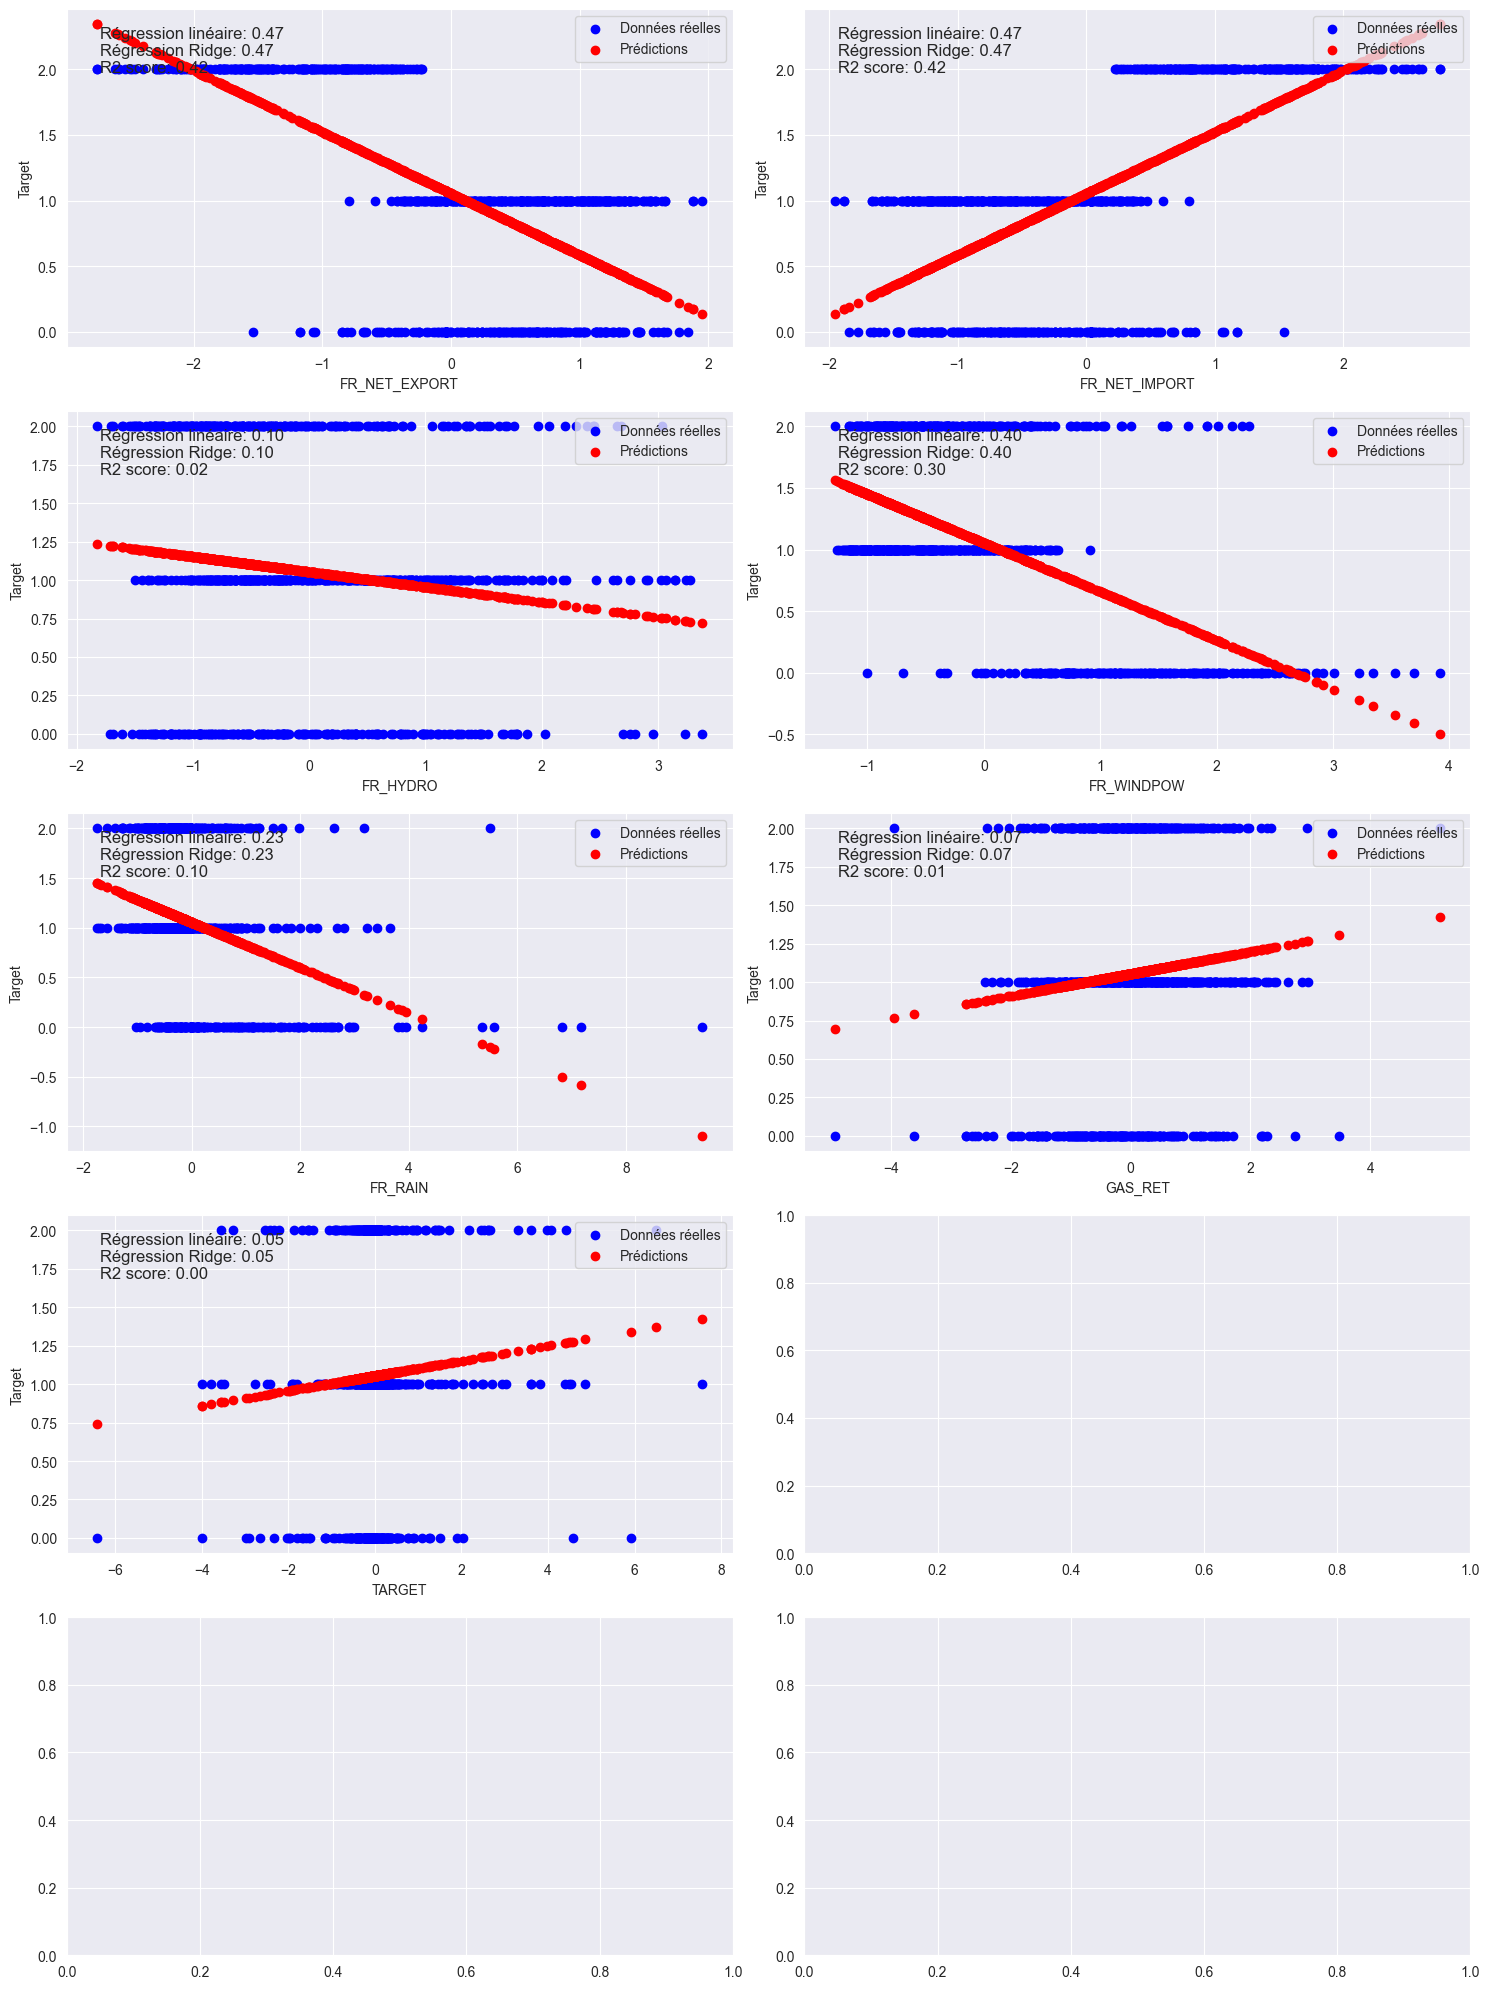

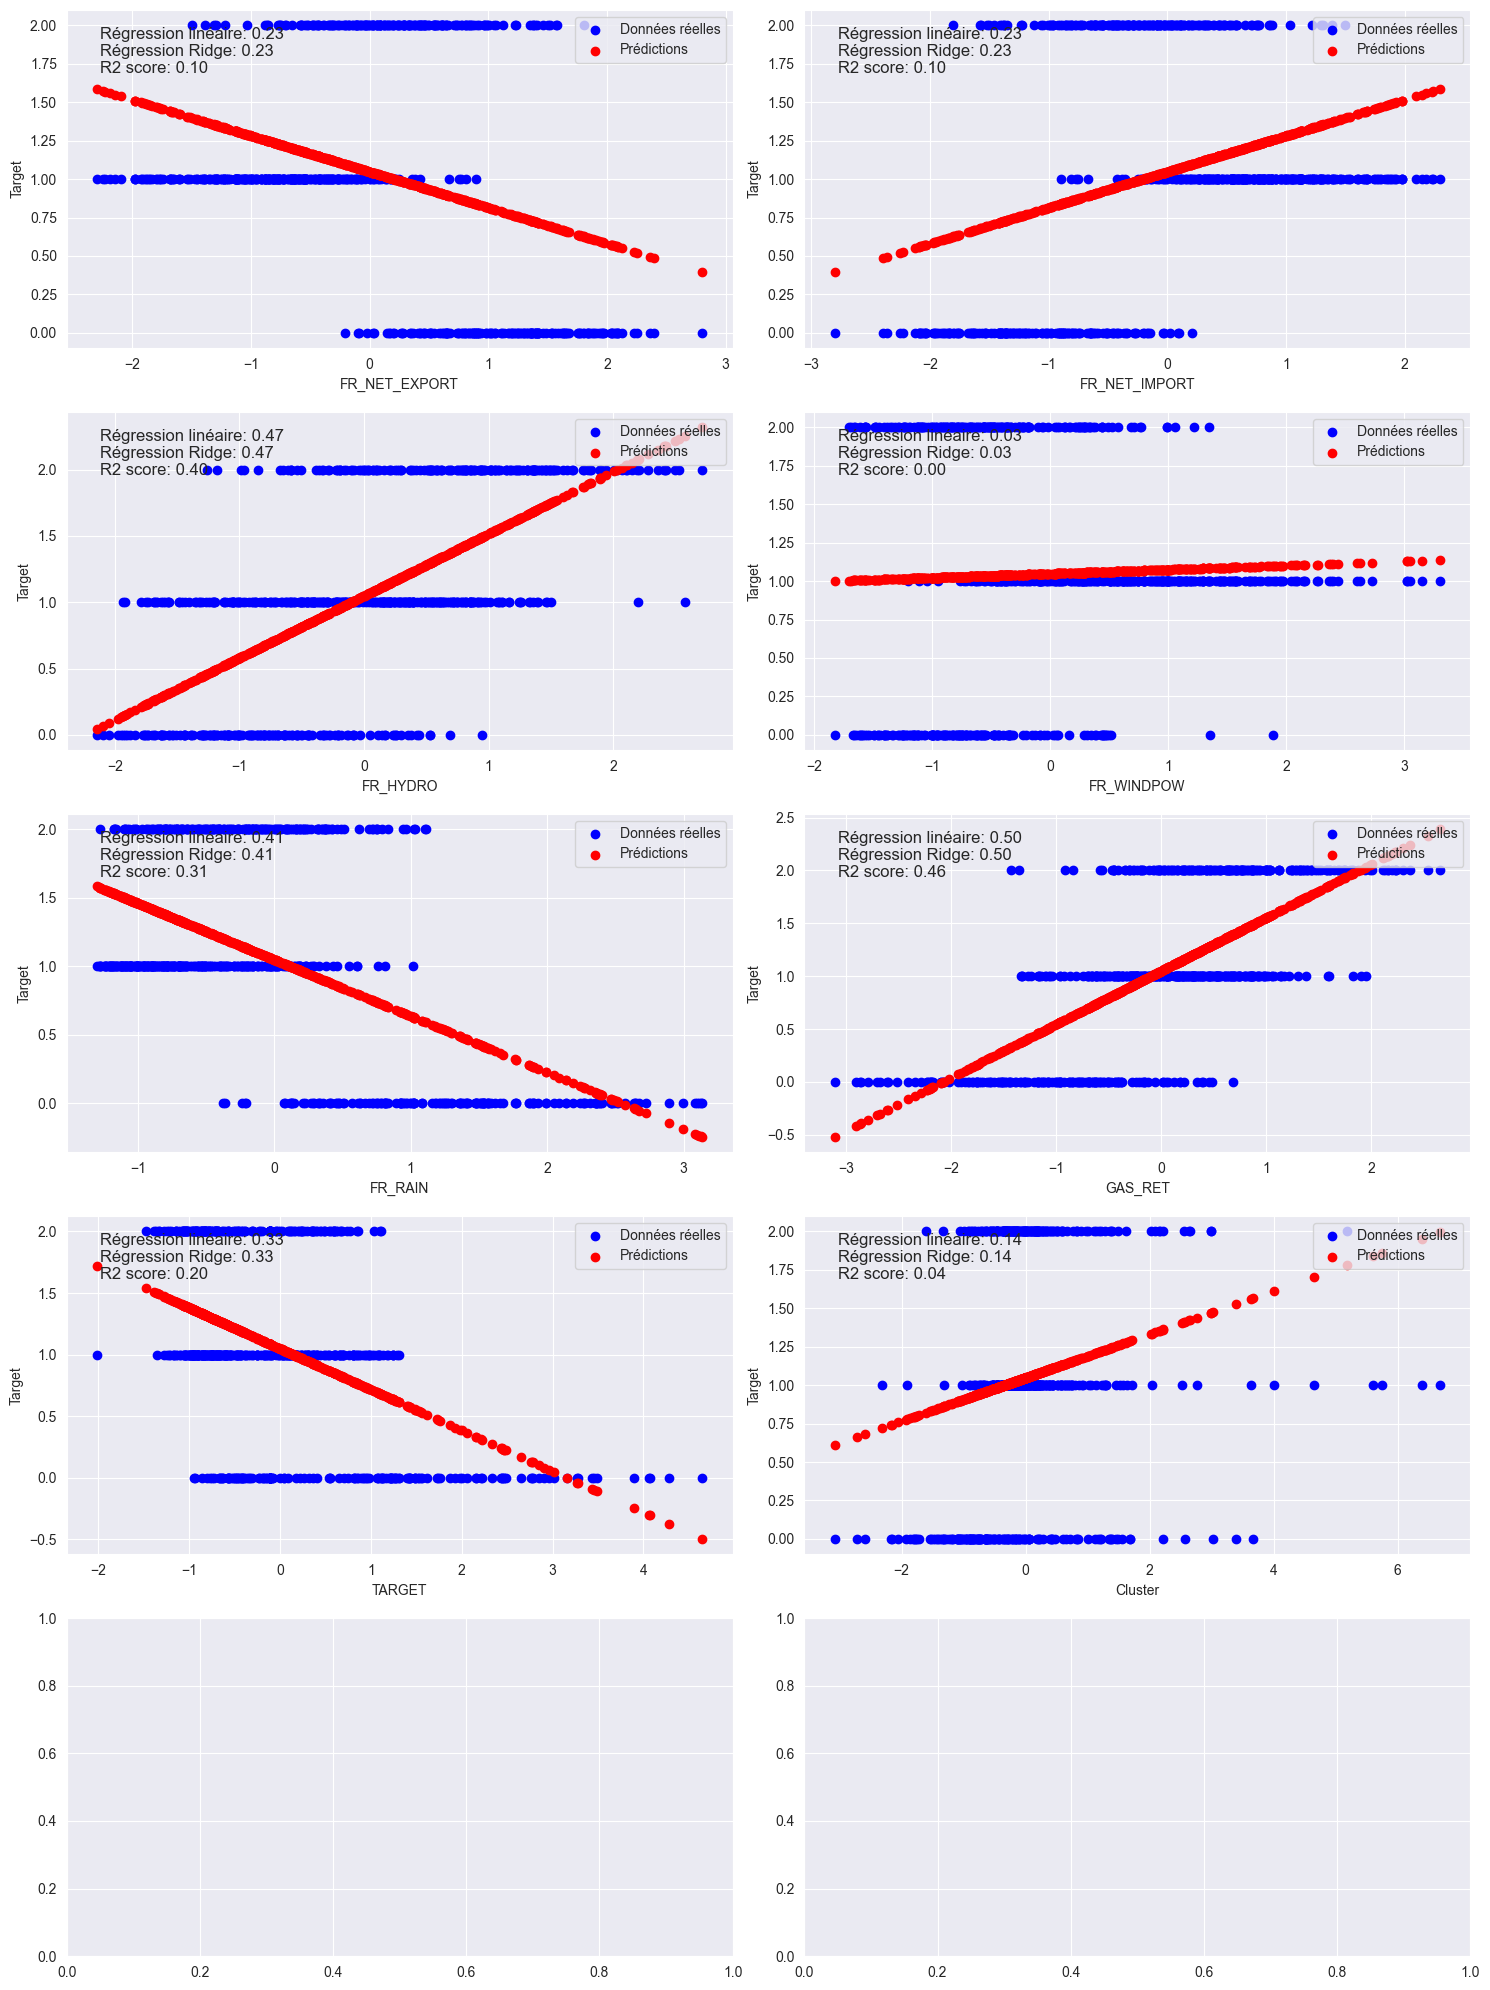

In [318]:
# REGRESSION RIDGE

# pour la France
import matplotlib.pyplot as plt

X = data_FR.iloc[:, :-1].values # On sélectionne toutes les colonnes sauf la dernière (target)
y = data_FR.iloc[:, -1].values # On sélectionne la dernière colonne (target)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Normalisation des données

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20)) # On crée une figure avec une grille de 5x2 subplots
axes = axes.flatten() # On transforme la matrice 2D des subplots en un vecteur 1D pour faciliter l'indexation

for i in range(X_scaled.shape[1]):
    # Régression linéaire
    lin = LinearRegression()
    lin.fit(X_scaled[:, i].reshape(-1, 1), y)
    lin_norm = np.linalg.norm(lin.coef_)
    # Régression ridge
    rid = Ridge(alpha=0.01)
    rid.fit(X_scaled[:, i].reshape(-1, 1), y)
    rid_norm = np.linalg.norm(rid.coef_)
    y_pred = rid.predict(X_scaled[:, i].reshape(-1, 1)) # On calcule les prédictions pour la colonne i
    axes[i].scatter(X_scaled[:, i], y, color='blue', label='Données réelles') # On trace le scatter plot pour la colonne i avec les données réelles en bleu
    axes[i].scatter(X_scaled[:, i], y_pred, color='red', label='Prédictions') # On ajoute les prédictions en rouge
    axes[i].set_xlabel(data_FR.columns[i]) # On ajoute le nom de la colonne i en tant que label de l'axe x
    axes[i].set_ylabel('Target') # On ajoute 'Target' en tant que label de l'axe y
    axes[i].legend(loc='upper right') # On ajoute une légende en haut à droite du subplot
    axes[i].text(0.05, 0.95, f"Régression linéaire: {lin_norm:.2f}\nRégression Ridge: {rid_norm:.2f}", transform=axes[i].transAxes, fontsize=12, verticalalignment='top') # On ajoute le texte avec les normes des coefficients pour la régression linéaire et la régression ridge
    r2_score = rid.score(X_scaled[:, i].reshape(-1, 1), y) # On calcule le R2 score pour la colonne i
    axes[i].text(0.05, 0.85, f"R2 score: {r2_score:.2f}", transform=axes[i].transAxes, fontsize=12, verticalalignment='top') # On ajoute le texte avec le R2 score pour la colonne i

plt.tight_layout() # On ajuste la disposition des subplots

# pour l'Allemagne
import matplotlib.pyplot as plt

X = data_DE.iloc[:, :-1].values # On sélectionne toutes les colonnes sauf la dernière (target)
y = data_DE.iloc[:, -1].values # On sélectionne la dernière colonne (target)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Normalisation des données

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20)) # On crée une figure avec une grille de 5x2 subplots
axes = axes.flatten() # On transforme la matrice 2D des subplots en un vecteur 1D pour faciliter l'indexation

for i in range(X_scaled.shape[1]):
    # Régression linéaire
    lin = LinearRegression()
    lin.fit(X_scaled[:, i].reshape(-1, 1), y)
    lin_norm = np.linalg.norm(lin.coef_)
    # Régression ridge
    rid = Ridge(alpha=0.01)
    rid.fit(X_scaled[:, i].reshape(-1, 1), y)
    rid_norm = np.linalg.norm(rid.coef_)
    y_pred = rid.predict(X_scaled[:, i].reshape(-1, 1)) # On calcule les prédictions pour la colonne i
    axes[i].scatter(X_scaled[:, i], y, color='blue', label='Données réelles') # On trace le scatter plot pour la colonne i avec les données réelles en bleu
    axes[i].scatter(X_scaled[:, i], y_pred, color='red', label='Prédictions') # On ajoute les prédictions en rouge
    axes[i].set_xlabel(data_FR.columns[i]) # On ajoute le nom de la colonne i en tant que label de l'axe x
    axes[i].set_ylabel('Target') # On ajoute 'Target' en tant que label de l'axe y
    axes[i].legend(loc='upper right') # On ajoute une légende en haut à droite du subplot
    axes[i].text(0.05, 0.95, f"Régression linéaire: {lin_norm:.2f}\nRégression Ridge: {rid_norm:.2f}", transform=axes[i].transAxes, fontsize=12, verticalalignment='top') # On ajoute le texte avec les normes des coefficients pour la régression linéaire et la régression ridge
    r2_score = rid.score(X_scaled[:, i].reshape(-1, 1), y) # On calcule le R2 score pour la colonne i
    axes[i].text(0.05, 0.85, f"R2 score: {r2_score:.2f}", transform=axes[i].transAxes, fontsize=12, verticalalignment='top') # On ajoute le texte avec le R2 score pour la colonne i

plt.tight_layout() # On ajuste la disposition des subplots

 Le R2 score est une mesure de la qualité de l'ajustement d'un modèle de régression aux données. Il indique la proportion de la variance totale des données qui est expliquée par le modèle. Il se situe entre 0 et 1. Plus le R2 score est élevé plus l'ajustement du modèle est parfait aux données.

Il est possible d'avoir un mauvais coefficient de ridge en même temps que d'avoir des points alignés selon la ligne régression.
En effet, la ligne de régression peut être influencée par des valeurs aberrantes ou des points qui sont très proches les uns des autres. Dans ce cas, la ligne de régression peut sembler bien alignée sur les données, mais cela ne signifie pas nécessairement que le modèle est bon ou que les coefficients de Ridge sont optimaux. Il est donc important de considérer plusieurs métriques de performance pour évaluer la qualité d'un modèle.

La régression Lasso est une technique de régression linéaire qui permet de sélectionner les variables les plus pertinentes pour prédire une variable cible. Elle fonctionne en ajoutant une pénalité à la somme des valeurs absolues des coefficients de la régression. Cette pénalité contraint les coefficients à être proches de zéro et permet donc de réduire le nombre de variables qui ont un impact négligeable sur la prédiction de la variable cible.

La régression Lasso est particulièrement utile dans des situations où il y a un grand nombre de variables explicatives potentielles, dont certaines sont redondantes ou peu informatives. Elle permet ainsi de réduire le nombre de variables à inclure dans le modèle final, ce qui peut améliorer la précision des prédictions et faciliter l'interprétation du modèle.

In [324]:
from tqdm import tqdm
from sklearn.linear_model import Lasso
from pandas import DataFrame

# REGRESSION LASSO

# pour la France
# Sépare les données en variables explicatives et cible
X = data_FR.iloc[:, :-1].values # On sélectionne toutes les colonnes sauf la dernière (target)
y = data_FR.iloc[:, -1].values # On sélectionne la dernière colonne (target)

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation des données en ensemble de train et test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entraînement du modèle Lasso pour différentes valeurs de lambda
res = []
for alf in tqdm([0.00001, 0.0001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4]):
    las = Lasso(alf).fit(X_train, y_train)
    r2 = r2_score(y_test, las.predict(X_test))
    res.append({'lambda': alf, 'r2': r2, 'nbnull': sum(las.coef_ == 0)})

# Affichage des résultats
df = DataFrame(res)
print(df.head(5))

# pour l'Allemagne
# Sépare les données en variables explicatives et cible
X = data_DE.iloc[:, :-1].values # On sélectionne toutes les colonnes sauf la dernière (target)
y = data_DE.iloc[:, -1].values # On sélectionne la dernière colonne (target)

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation des données en ensemble de train et test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entraînement du modèle Lasso pour différentes valeurs de lambda
res = []
for alf in tqdm([0.00001, 0.0001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4]):
    las = Lasso(alf).fit(X_train, y_train)
    r2 = r2_score(y_test, las.predict(X_test))
    res.append({'lambda': alf, 'r2': r2, 'nbnull': sum(las.coef_ == 0)})

# Affichage des résultats
df = DataFrame(res)
print(df.head(5))

  0%|          | 0/18 [00:00<?, ?it/s]


TypeError: 'numpy.float64' object is not callable

nbnull correspond au nombre de coefficients égale à 0, ce qui suggère qu'il n'y a pas beaucoup de variables redondantes et que la sélection de variables n'a pas un impact important sur la qualité de prédiction du modèle. Ici, nous avons sélectionné que les 5 premières valeurs pour plus de visibilité.



Lasso et Ridge sont deux techniques de régularisation pour la régression linéaire, qui permettent de réduire la complexité d'un modèle pour éviter le sur-apprentissage.

La principale différence entre Lasso et Ridge est que Lasso utilise une pénalité L1 (norme L1), qui a pour effet de pousser certains coefficients du modèle à zéro, ce qui permet de sélectionner les variables les plus importantes et de faire de la sélection de variable automatique. En revanche, Ridge utilise une pénalité L2 (norme L2), qui ne force pas les coefficients à zéro mais les diminue pour éviter le sur-apprentissage.

Ainsi, si l'on souhaite sélectionner les variables les plus importantes et faire de la sélection de variables automatique, Lasso est généralement plus adapté. Si l'on souhaite simplement réduire la complexité du modèle pour éviter le sur-apprentissage, Ridge peut être une meilleure option.

In [325]:
from sklearn.tree import DecisionTreeRegressor

# Séparez les variables explicatives et la variable cible
X = data_DE.drop('TARGET', axis=1)
Y = data_DE['TARGET']

# Divisez les données en ensembles d'apprentissage et de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Créez une instance du modèle d'arbre de décision pour la régression
tree_model = DecisionTreeRegressor(random_state=42)

# Entraînez le modèle sur les données d'apprentissage
tree_model.fit(X_train, Y_train)

# Faites des prédictions sur les données de test
Y_pred = tree_model.predict(X_test)

# Évaluez les performances du modèle
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print("Mean Squared Error (MSE): {:.2f}".format(mse))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
print("Coefficient of Determination (R^2): {:.2f}".format(r2))

# Affichez les prédictions en utilisant un diagramme de dispersion
plt.figure(figsize=(10, 6))
sns.scatterplot(x=Y_test, y=Y_pred)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
plt.xlabel('Valeur réelle')
plt.ylabel('Prédiction')
plt.title('Prédiction vs Valeur réelle (Arbre de décision pour la régression)')
plt.show()

TypeError: 'numpy.float64' object is not callable

In [272]:
from scipy.stats import spearmanr

# Calcul de la corrélation de Spearman pour data_FR
corr_FR = []
for i in range(data_FR.shape[1]):
    for j in range(i+1, data_FR.shape[1]):
        corr, _ = spearmanr(data_FR.iloc[:,i], data_FR.iloc[:,j])
        corr_FR.append([data_FR.columns[i], data_FR.columns[j], corr])

# Calcul de la corrélation de Spearman pour data_DE
corr_DE = []
for i in range(data_DE.shape[1]):
    for j in range(i+1, data_DE.shape[1]):
        corr, _ = spearmanr(data_DE.iloc[:,i], data_DE.iloc[:,j])
        corr_DE.append([data_DE.columns[i], data_DE.columns[j], corr])


# Spearman correlation for data_FR
corr_FR, _ = spearmanr(data_FR)
print("Spearman correlation for data_FR:\n", corr_FR)

# Spearman correlation for data_DE
corr_DE, _ = spearmanr(data_DE)
print("\nSpearman correlation for data_DE:\n", corr_DE)

Spearman correlation for data_FR:
 [[ 1.         -1.          0.1118785   0.06825881  0.02634929  0.01986123
  -0.0122066 ]
 [-1.          1.         -0.1118785  -0.06825881 -0.02634929 -0.01986123
   0.0122066 ]
 [ 0.1118785  -0.1118785   1.         -0.01782728  0.06774703 -0.01143171
   0.07170877]
 [ 0.06825881 -0.06825881 -0.01782728  1.          0.2838337  -0.08925752
  -0.12152975]
 [ 0.02634929 -0.02634929  0.06774703  0.2838337   1.          0.01764631
  -0.02832946]
 [ 0.01986123 -0.01986123 -0.01143171 -0.08925752  0.01764631  1.
   0.14895647]
 [-0.0122066   0.0122066   0.07170877 -0.12152975 -0.02832946  0.14895647
   1.        ]]

Spearman correlation for data_DE:
 [[ 1.         -1.         -0.22488472 -0.47712199  0.76336028 -0.38378465
   0.2939062  -0.30620422]
 [-1.          1.          0.22488472  0.47712199 -0.76336028  0.38378465
  -0.2939062   0.30620422]
 [-0.22488472  0.22488472  1.          0.0929137  -0.44583477  0.73676493
  -0.44467483  0.25340952]
 [-0.47712